# Plot XY, XXP, YYP, ZDE, TDPP, Tune footprints & X, Y profiles

In [1]:
import os
import sys
import glob
import time
#import pickle
#import imageio
import numpy as np
#import pandas as pd
#import PyNAFF as pnf

from math import log10, floor

import scipy.io as sio
from scipy.optimize import curve_fit
from scipy.stats import moment, kurtosis

import matplotlib
#matplotlib.use('Agg')   # suppress opening of plots
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

start_time = time.time()

### Figure parameters

In [2]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

### Function Declarations

In [3]:
class resonance_lines(object):
	
	def __init__(self, Qx_range, Qy_range, orders, periodicity):
		
		if np.std(Qx_range):
			self.Qx_min = np.min(Qx_range)
			self.Qx_max = np.max(Qx_range)
		else:
			self.Qx_min = np.floor(Qx_range)-0.05
			self.Qx_max = np.floor(Qx_range)+1.05
		if np.std(Qy_range):
			self.Qy_min = np.min(Qy_range)
			self.Qy_max = np.max(Qy_range)
		else:
			self.Qy_min = np.floor(Qy_range)-0.05
			self.Qy_max = np.floor(Qy_range)+1.05

		self.periodicity = periodicity
									
		nx, ny = [], []

		for order in np.nditer(np.array(orders)):
			t = np.array(range(-order, order+1))
			nx.extend(order - np.abs(t))
			ny.extend(t)
		nx = np.array(nx)
		ny = np.array(ny)

		cextr = np.array([nx*np.floor(self.Qx_min)+ny*np.floor(self.Qy_min), \
						  nx*np.ceil(self.Qx_max)+ny*np.floor(self.Qy_min), \
						  nx*np.floor(self.Qx_min)+ny*np.ceil(self.Qy_max), \
						  nx*np.ceil(self.Qx_max)+ny*np.ceil(self.Qy_max)], dtype='int')
		cmin = np.min(cextr, axis=0)
		cmax = np.max(cextr, axis=0)
		res_sum = [range(cmin[i], cmax[i]+1) for i in xrange(cextr.shape[1])]
		self.resonance_list = zip(nx, ny, res_sum)
		
	def plot_resonance(self, figure_object = None):	
		plt.ion()
		if figure_object:
			fig = figure_object
			plt.figure(fig.number)
		else:
			fig = plt.figure()
		Qx_min = self.Qx_min
		Qx_max = self.Qx_max
		Qy_min = self.Qy_min
		Qy_max = self.Qy_max 
		plt.xlim(Qx_min, Qx_max)
		plt.ylim(Qy_min, Qy_max)
		plt.xlabel('Qx')
		plt.ylabel('Qy')
		for resonance in self.resonance_list:
			nx = resonance[0]
			ny = resonance[1]
			for res_sum in resonance[2]:
				if ny:
					line, = plt.plot([Qx_min, Qx_max], \
					    [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny])
				else:
					line, = plt.plot([np.float(res_sum)/nx, np.float(res_sum)/nx],[Qy_min, Qy_max])
				if ny%2:
					plt.setp(line, linestyle='--') # for skew resonances
				if res_sum%self.periodicity:
					plt.setp(line, color='b')	# non-systematic resonances
				else:
					plt.setp(line, color='r', linewidth=2.0) # systematic resonances
		plt.draw()
		return fig

	def print_resonances(self):
		for resonance in self.resonance_list:
			for res_sum in resonance[2]:
				'''
				print str(resonance[0]).rjust(3), 'Qx ', ("+", "-")[resonance[1]<0], \
					  str(abs(resonance[1])).rjust(2), 'Qy = ', str(res_sum).rjust(3), \
					  '\t', ("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0]
				'''
				print '%s %s%s = %s\t%s'%(str(resonance[0]).rjust(2), ("+", "-")[resonance[1]<0], \
						str(abs(resonance[1])).rjust(2), str(res_sum).rjust(4), \
						("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0])


In [4]:
def gaussian(x, A, mu, sig):
    """gaussian_3_parameter(x, A, mu, sig)"""
    return A*np.exp(-(x-mu)**2/(2*sig**2))
    
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)
    
def add_input_file(dd, filename, label):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

def z_to_time(z, gamma = 2.49038064): #beta for 2 GeV
    c = 299792458
    return z / (c * beta_from_gamma(gamma))
    
def E_from_gamma(gamma):
    return (gamma*938.27208816E6)
    
def beta_from_gamma(gamma):
    return (np.sqrt(1 - (1/gamma**2)))
    
def gamma_from_beta(beta):
    return (1./np.sqrt(1.-beta**2))    
    
def dpp_from_dE(dE, gamma = 2.49038064):
	return (dE / (E_from_gamma(gamma)*1E-9 * beta_from_gamma(gamma)**2))

def dE_from_dpp(dpp, gamma = 2.49038064):
	return (dpp * E_from_gamma(gamma)*1E-9 * beta_from_gamma(gamma)**2)

def check_if_fig_exists(name):
    ret_val = False
    if os.path.isfile(name):
        print name, ' already exists, plotting skipped'
        ret_val = True
    return ret_val

def gaussian_(x,a,b,c,d):
            return a + b*np.exp(-(x-c)**2/(2*d**2))
    
def gaussfromdist(particles, n_cut, bins_per_sigma = 10, ws_res = 0):
       
    bin_rms = np.std(particles)
    #print 'gaussfromdist::bins_rms =', bin_rms
   
    if ws_res == 0:
        a = np.histogram(particles, range = (-bin_rms*n_cut, bin_rms*n_cut), bins = bins_per_sigma*n_cut, normed = True)
        popt, pcov = curve_fit(gaussian_,a[1][:-1],a[0],method = 'trf',bounds =((-np.max(a[0])*1E-3,np.max(a[0])*0.8,np.min(a[1]),0),(np.max(a[0])*1E-3,np.max(a[0])*1.2,np.max(a[1]),np.max(a[1]))))

        dbin = bin_rms/bins_per_sigma
   
        return a, popt, pcov, dbin
   
    else:
        a = np.histogram(particles, range = (-bin_rms*n_cut, bin_rms*n_cut), bins = np.int(bin_rms*n_cut/ws_res), normed = True)
        popt, pcov = curve_fit(gaussian_, a[1][:-1], a[0], method = 'trf', bounds =((-np.max(a[0])*1E-3,np.max(a[0])*0.8,np.min(a[1]),0),(np.max(a[0])*1E-3,np.max(a[0])*1.2,np.max(a[1]),np.max(a[1]))))
        
        dbin = ws_res
       
        return a, popt, pcov, dbin


## User settings

In [5]:
print '\n\tPLOTTING SCRIPT: TUNE AND DISTRIBUTION FOOTPRINTS FROM PTC-PYORBIT BUNCH OUTPUT FILES: STARTED'

LIU = False

TUNE = True
XY = True
XXP = True
YYP = True
ZDE = True
TDPP = True
X_Profile = True
Y_Profile = True

tune_tit = '(6.21, 6.245)'
tune_sav = '6p21_6p245' 
sc = 'SbS'
main_label = 'OP'

source_dir =  './bunch_output/'
save_folder = source_dir

master_bins = 512


	PLOTTING SCRIPT: TUNE AND DISTRIBUTION FOOTPRINTS FROM PTC-PYORBIT BUNCH OUTPUT FILES: STARTED


In [6]:
# Setup
#-----------------------------------------------------------------------
gamma_2GeV = 3.131540798    # From PTC Twiss
gamma_1p4GeV = 2.49038064   # From PTC Twiss

beta_2GeV = beta_from_gamma(gamma_2GeV)
beta_1p4GeV = beta_from_gamma(gamma_1p4GeV)

E_2GeV = E_from_gamma(gamma_2GeV)
E_1p4GeV = E_from_gamma(gamma_1p4GeV)

if LIU:
    lorentz_beta = beta_2GeV
    lorentz_gamma = gamma_2GeV
    E_tot = E_2GeV
    print '\n\t LIU Beam Settings:\n\t Lorentz Gamma = ', round_sig(lorentz_gamma,5), '\n\t Lorentz Beta = ', round_sig(lorentz_beta,5), '\n\t Total Energy = ', round_sig(E_tot,10)
    
else:
    lorentz_beta = beta_1p4GeV
    lorentz_gamma = gamma_1p4GeV
    E_tot = E_1p4GeV
    print '\n\t PreLIU Beam Settings:\n\t Lorentz Gamma = ', round_sig(lorentz_gamma,5), '\n\t Lorentz Beta = ', round_sig(lorentz_beta,5), '\n\t Total Energy = ', round_sig(E_tot,10)

betagamma = lorentz_beta * lorentz_gamma



	 PreLIU Beam Settings:
	 Lorentz Gamma =  2.4904 
	 Lorentz Beta =  0.91584 
	 Total Energy =  2336654643.0


## Import all data

In [7]:
# Load files
#-----------------------------------------------------------------------
plt.close('all')

filename = 'mainbunch'
files = glob.glob(source_dir + filename + '*.mat')
files.sort()

print '\n\tFound input files for turns: '
for f in files:
    print ' ', f.split('.')[1][-6:]


	Found input files for turns: 
  000001
  000002


	  x  profile: Plotting  OP  scan tune = (6.21, 6.245)  turn =  1

	  x  profile:  x  limit set to  14.7

	  x  profile: y_dat_lim limit set to  176.0
	  x  profile: Plotting  OP  scan tune = (6.21, 6.245)  turn =  2


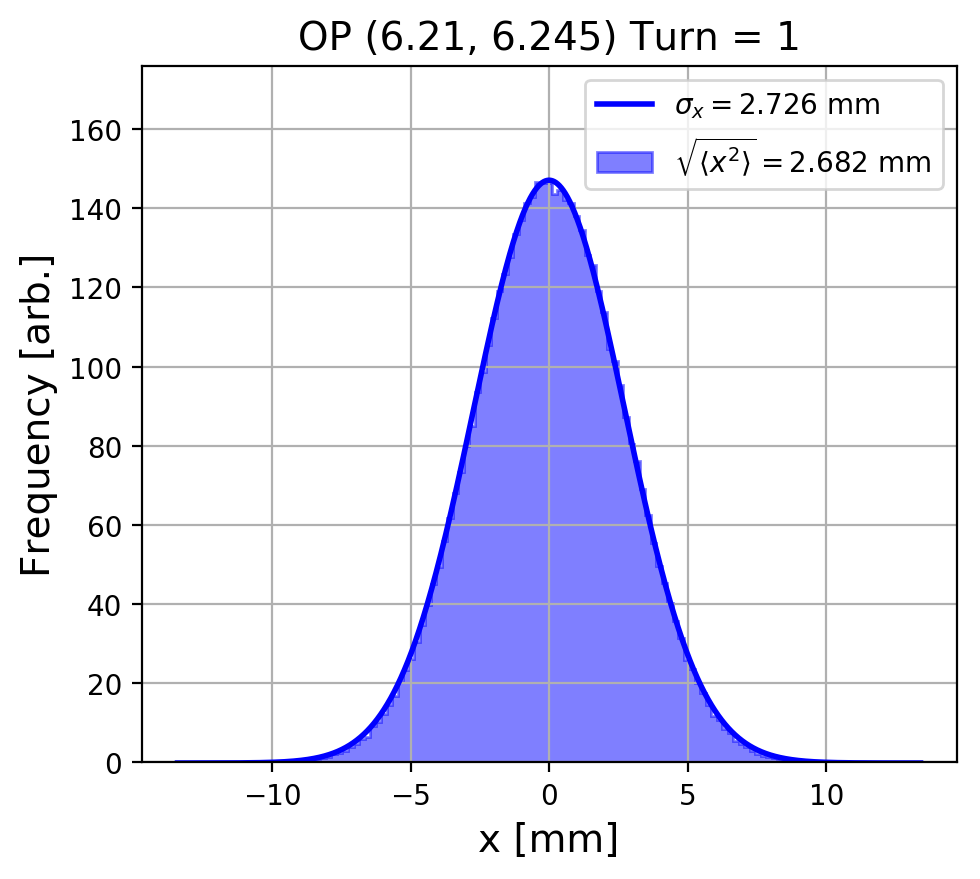

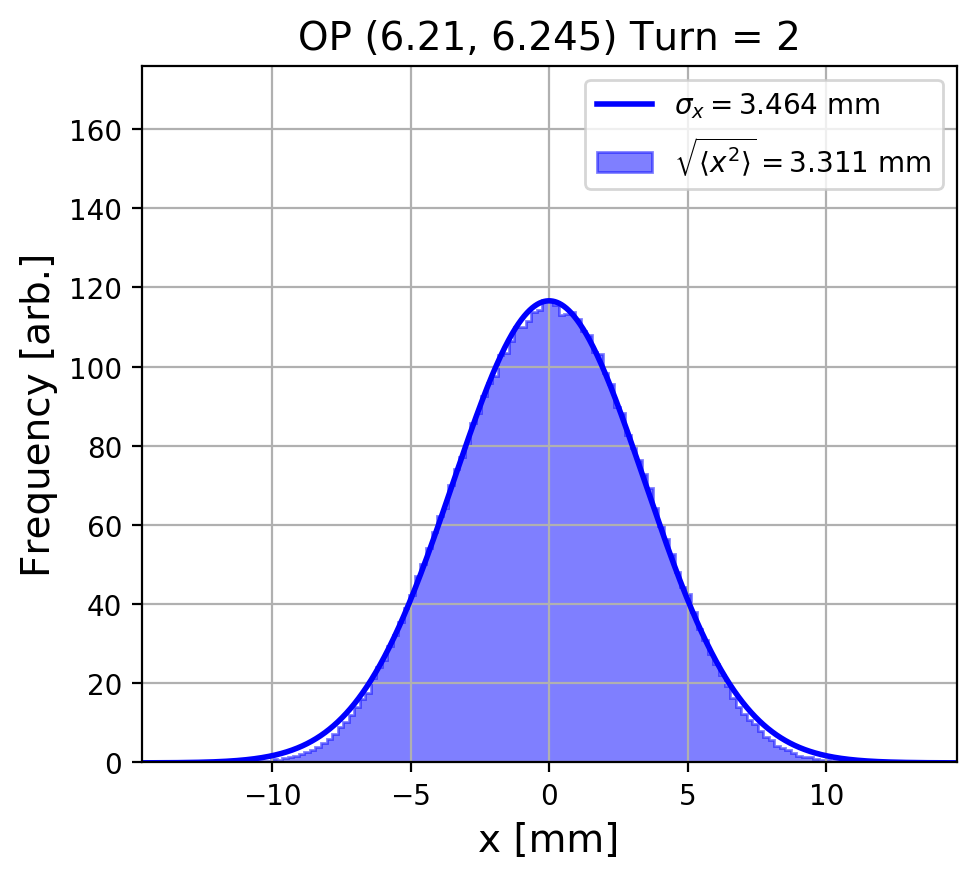

In [8]:
if X_Profile:
#-----------------------------------------------------------------------  
# PLOT X Profile
#-----------------------------------------------------------------------    
    x_gifs =[]
    
    x_lab = 'x'
    x_unit = 'mm'
    
    x_dat_lim = 10.
    y_dat_lim = 10.
    
    first_turn = True
    
    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
        savename = str(save_folder + x_lab+'_profile_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:
            print '\t ',x_lab,' profile: Plotting ', main_label, ' scan tune =', tune_tit, ' turn = ', turn
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            x_dat = particles.x
            
            a, popt, pcov, dbin = gaussfromdist(x_dat, 5, ws_res = 100e-6)
            bin_width = a[1][1] - a[1][0]
            half_bin_width = bin_width/2    
            x_ = np.arange(a[1][0], a[1][-1], 1E-5)*1e3   
            mean_x_dat = np.mean(x_dat)
            x_std = np.std(x_dat)*1E3
            x_offset = -mean_x_dat + half_bin_width
                        
            plt.figure()
            
            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            plt.title(title)
            
            plt.plot(x_, gaussian_(x_,popt[0],popt[1], 0, popt[3]*1e3), color = 'b', lw = 2,label = str(r'$\sigma_x = $' + str(round(popt[3]*1E3,3)) + ' mm'))  
            plt.hist((a[1][:-1] + x_offset)*1e3, len(a[1][:-1]), weights=a[0], density = False, histtype='step', color = 'b', fill=True, alpha = 0.5, label =  (r'$\sqrt{\langle x^2 \rangle} = $' + str(round(x_std,3)) + ' mm' ))

            if first_turn:
                 
                x_dat_max = np.max(x_dat)*1E3
                x_dat_min = np.min(x_dat)*1E3                    
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round_sig(-1*x_dat_min*1.2, 3) 
                else:
                    x_dat_lim = round_sig(x_dat_max*1.2, 3)      
                    
                if np.max(a[0]) > y_dat_lim:
                    y_dat_lim = round_sig(np.max(a[0]*1.2), 3) 
                       
                print '\n\t ',x_lab,' profile: ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,' profile: y_dat_lim limit set to ', y_dat_lim
                
                first_turn = False
            
            plt.grid()
            plt.legend()
            plt.xlim(-x_dat_lim,x_dat_lim)
            plt.ylim(0,y_dat_lim)
            plt.xlabel(str(x_lab+' ['+ x_unit +']'))
            plt.ylabel('Frequency [arb.]')
            plt.tight_layout()
            plt.savefig(savename)
            #plt.close()

	  y  profile: Plotting  OP  scan tune = (6.21, 6.245)  turn =  1

	  y  profile:  y  limit set to  17.2

	  y  profile: y_dat_lim limit set to  158.0
	  y  profile: Plotting  OP  scan tune = (6.21, 6.245)  turn =  2


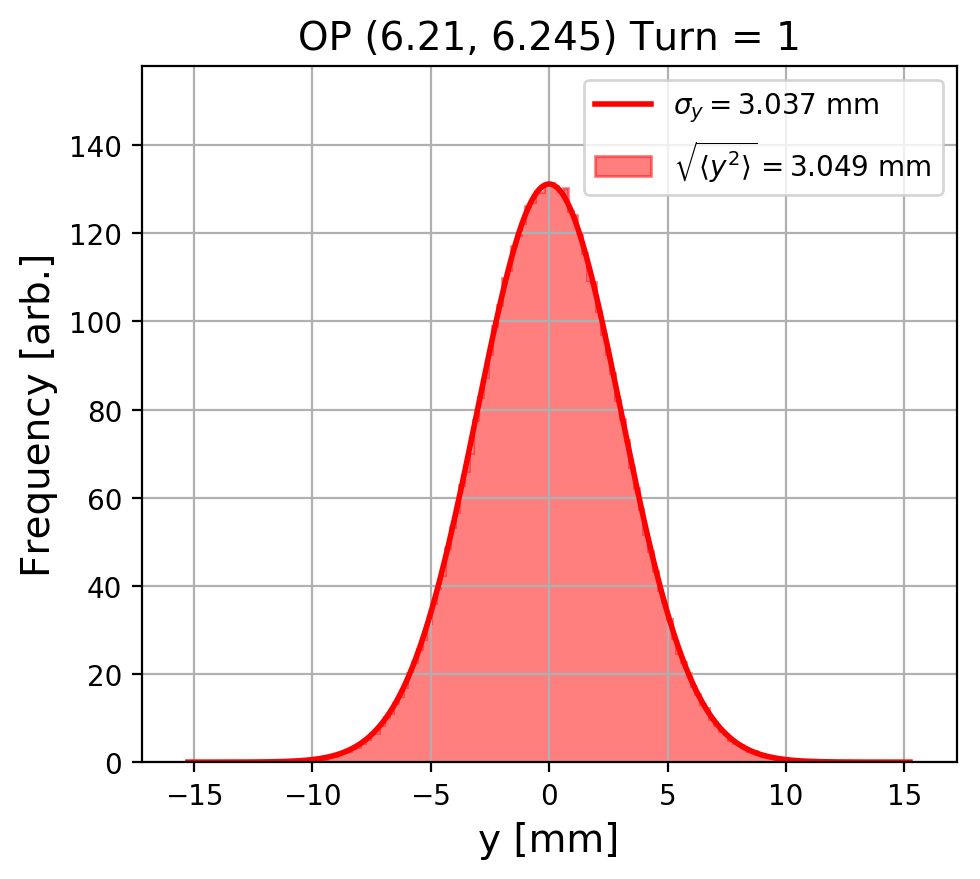

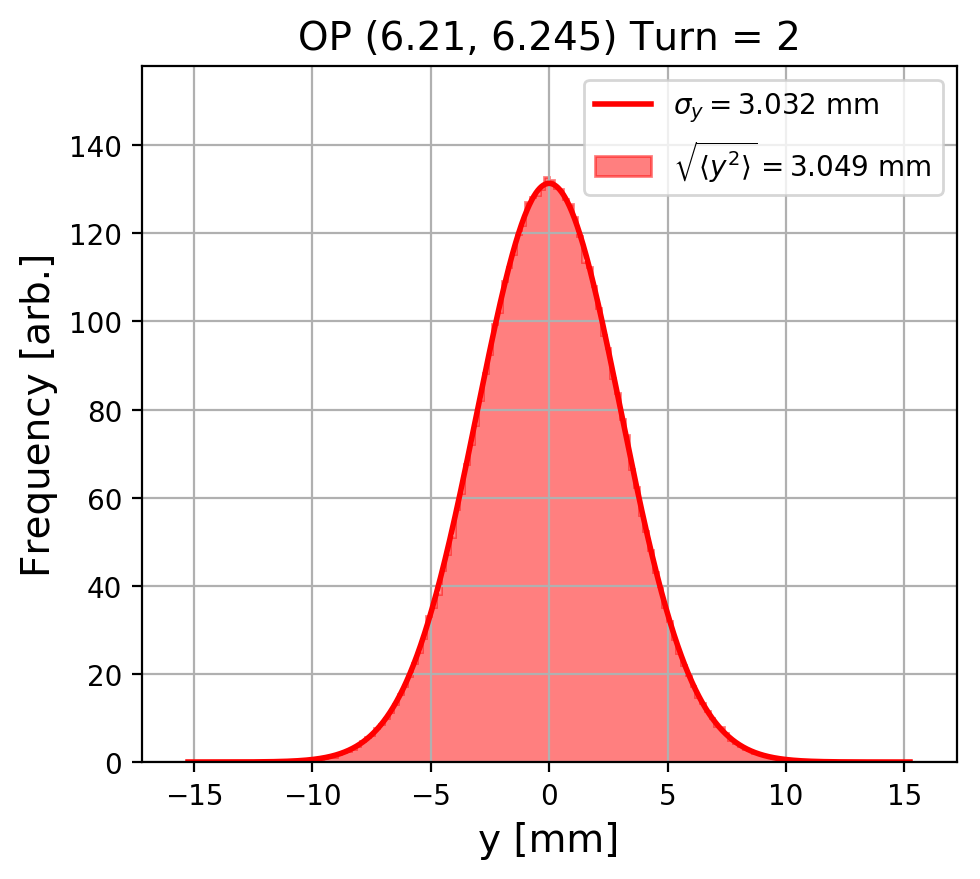

In [9]:
if Y_Profile:
#-----------------------------------------------------------------------  
# PLOT Y Profile
#-----------------------------------------------------------------------    
    x_gifs =[]
    
    x_lab = 'y'
    x_unit = 'mm'
    
    x_dat_lim = 10.
    y_dat_lim = 10.
    
    first_turn = True
    
    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
        savename = str(save_folder + x_lab+'_profile_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:
            print '\t ',x_lab,' profile: Plotting ', main_label, ' scan tune =', tune_tit, ' turn = ', turn
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            x_dat = particles.y
            
            a, popt, pcov, dbin = gaussfromdist(x_dat, 5, ws_res = 100e-6)
            bin_width = a[1][1] - a[1][0]
            half_bin_width = bin_width/2    
            x_ = np.arange(a[1][0], a[1][-1], 1E-5)*1e3   
            mean_x_dat = np.mean(x_dat)
            x_std = np.std(x_dat)*1E3
            x_offset = -mean_x_dat + half_bin_width
                        
            plt.figure()
            
            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            plt.title(title)
            
            plt.plot(x_, gaussian_(x_,popt[0],popt[1], 0, popt[3]*1e3), color = 'r', lw = 2,label = str(r'$\sigma_y = $' + str(round(popt[3]*1E3,3)) + ' mm'))  
            plt.hist((a[1][:-1] + x_offset)*1e3, len(a[1][:-1]), weights=a[0], density = False, histtype='step', color = 'r', fill=True, alpha = 0.5, label =  (r'$\sqrt{\langle y^2 \rangle} = $' + str(round(x_std,3)) + ' mm' ))

            if first_turn:
                 
                x_dat_max = np.max(x_dat)*1E3
                x_dat_min = np.min(x_dat)*1E3                    
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round_sig(-1*x_dat_min*1.2, 3) 
                else:
                    x_dat_lim = round_sig(x_dat_max*1.2, 3)      
                    
                if np.max(a[0]) > y_dat_lim:
                    y_dat_lim = round_sig(np.max(a[0]*1.2), 3) 
                       
                print '\n\t ',x_lab,' profile: ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,' profile: y_dat_lim limit set to ', y_dat_lim
                
                first_turn = False
            
            plt.grid()
            plt.legend()
            plt.xlim(-x_dat_lim,x_dat_lim)
            plt.ylim(0,y_dat_lim)
            plt.xlabel(str(x_lab+' ['+ x_unit +']'))
            plt.ylabel('Frequency [arb.]')
            plt.tight_layout()
            plt.savefig(savename)
            #plt.close()

	 XY: Plotting  OP   x - y  scan tune = (6.21, 6.245)  turn =  1  with histograms

	  x - y :  x  limit set to  18.42

	  x - y :  y  limit set to  21.525

	  x - y : max_x_hist set to  0.165

	  x - y : max_y_hist set to  0.143
	 XY: Plotting  OP   x - y  scan tune = (6.21, 6.245)  turn =  2  with histograms


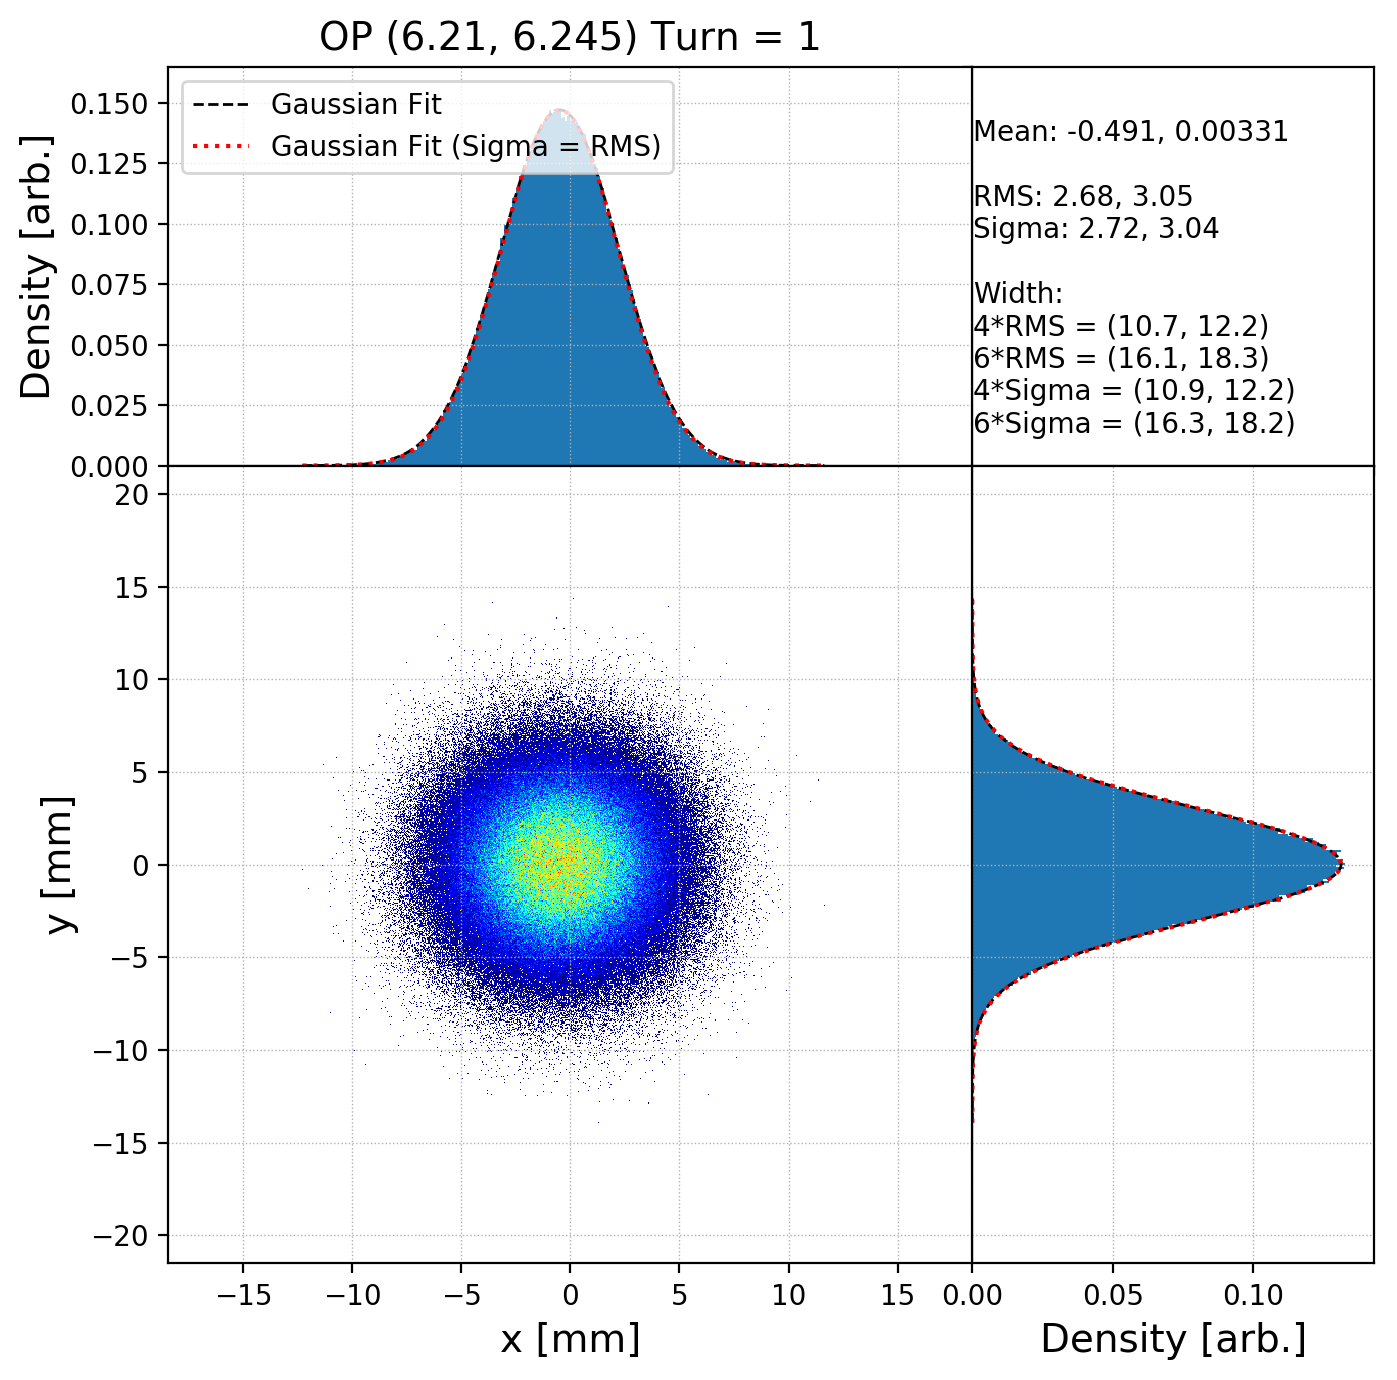

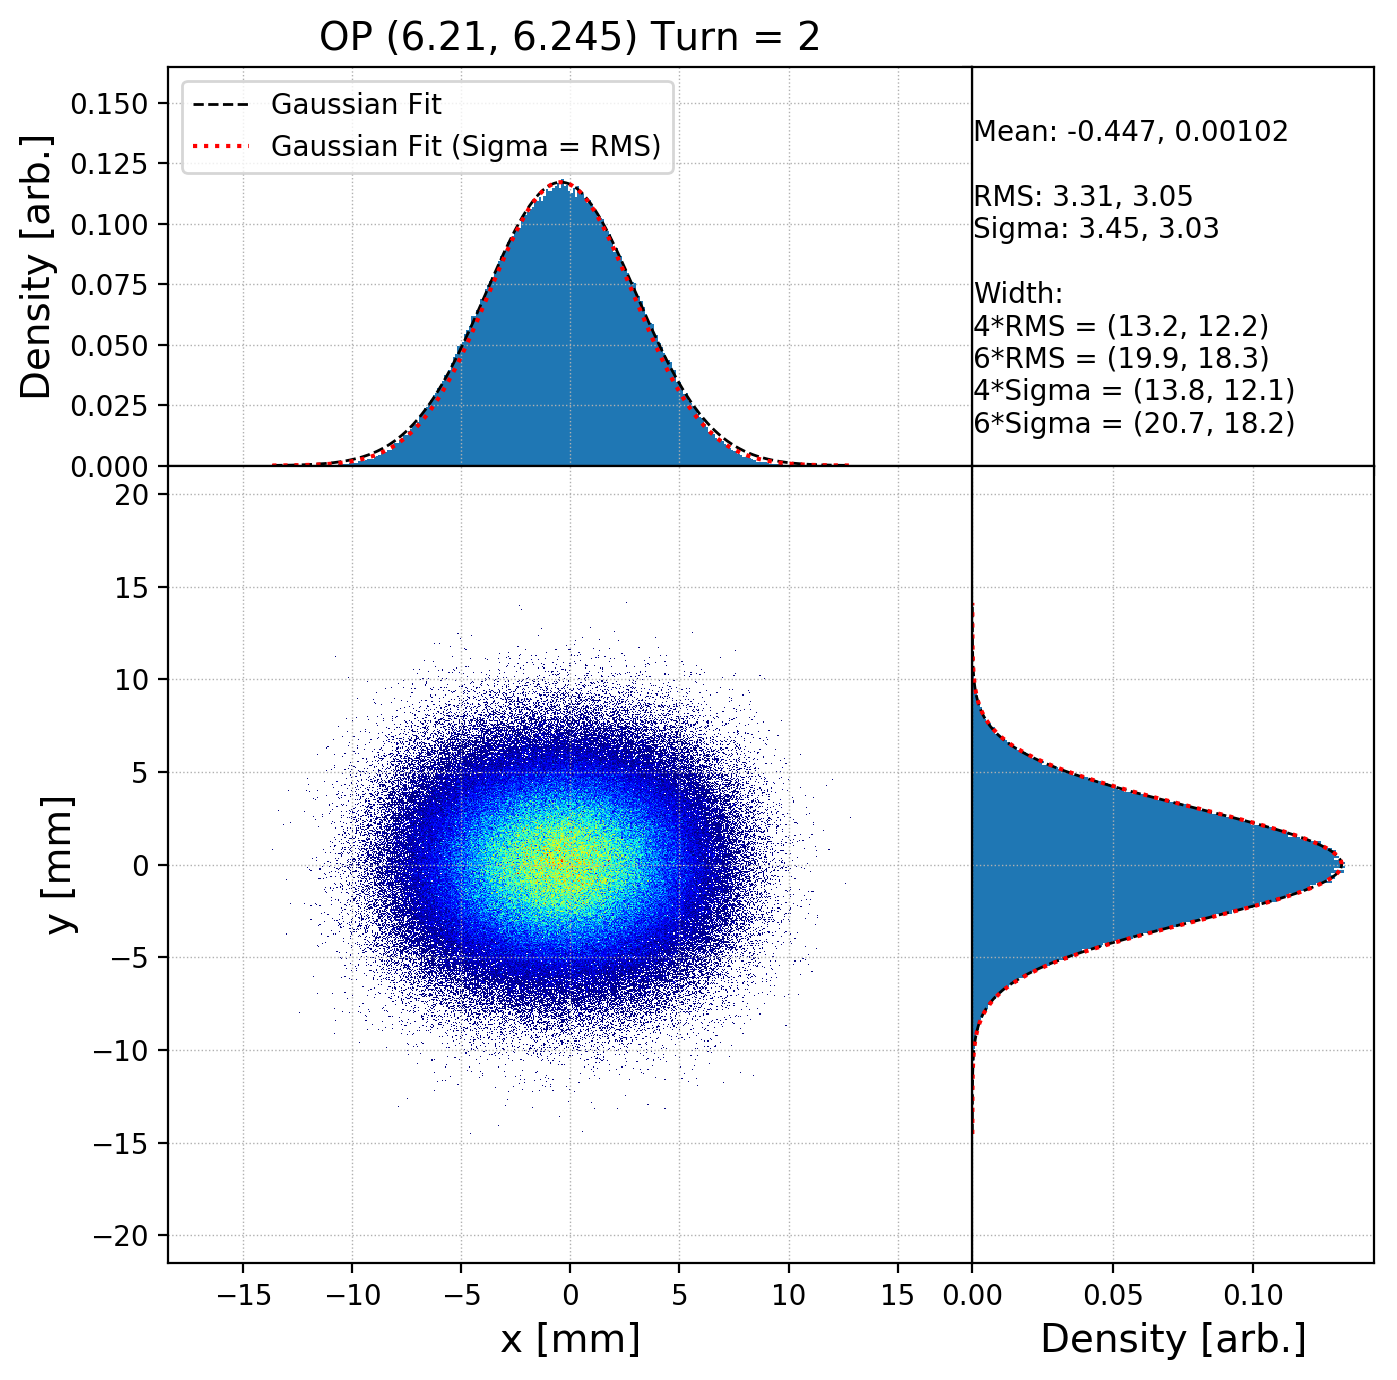

In [10]:

if XY:
#-----------------------------------------------------------------------  
# PLOT XY
#-----------------------------------------------------------------------    
    xy_gifs =[]

    x_dat_lim = 10.
    y_dat_lim = 1.
    max_x_hist = 0.01
    max_y_hist = 0.01

    x_lab = 'x'
    y_lab = 'y'
    x_unit = 'mm'
    y_unit = 'mm'

    first_turn = True
    first_turn_again = True

    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
        savename = str(save_folder + 'XY_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:

                
            print '\t XY: Plotting ', main_label, ' ',x_lab,'-',y_lab, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
            
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            # ~ x  = particles.x * 1E3;
            # ~ xp = particles.xp* 1E3;
            # ~ y  = particles.y * 1E3;
            # ~ yp = particles.yp* 1E3;
            # ~ z  = particles.z * 1E9;
            # ~ dE = particles.dE;
            x_dat = particles.x * 1E3
            y_dat = particles.y * 1E3
            

            my_cmap = plt.cm.jet
            my_cmap.set_under('w',1)

            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            
            fig = plt.figure(figsize=(7,7))
            gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
         
            # Calculate RMS Qx and Qy
            #-------------------------------------------------------------------
            x_dat_rms = np.sqrt(moment(x_dat,2))
            y_dat_rms = np.sqrt(moment(y_dat,2))
            x_dat_min = np.min(x_dat)
            x_dat_max = np.max(x_dat)
            y_dat_min = np.min(y_dat)
            y_dat_max = np.max(y_dat) 
            x_dat_4sig = 4 * x_dat_rms
            y_dat_4sig = 4 * y_dat_rms
            x_dat_6sig = 6 * x_dat_rms
            y_dat_6sig = 6 * y_dat_rms
            
            x_fine = np.arange(x_dat_min, x_dat_max, 1E-3)
            y_fine = np.arange(y_dat_min, y_dat_max, 1E-3)
            
            # TEXT BOX (top right)
            #-------------------------------------------------------------------
            ax4 = fig.add_subplot(gs[0, 2:3])
            ax4.set_yticklabels([])
            ax4.set_xticklabels([])
            
            # FIRST SUBPLOT - x histogram
            #-------------------------------------------------------------------
            ax1 = fig.add_subplot(gs[0, 0:2])
            ax1.set_title(title)    
            n_x, bins_x, patches_x = ax1.hist(x_dat, bins=master_bins/2, range=(np.min(x_dat), np.max(x_dat)), density=True)
            bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins
            
            if first_turn:
                x_dat_max = np.max(x_dat)
                x_dat_min = np.min(x_dat)       
                
                y_dat_max = np.max(y_dat)
                y_dat_min = np.min(y_dat)           
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round(-1*x_dat_min, 2) * 1.5
                else:
                    x_dat_lim = round(x_dat_max, 2) * 1.5     
                       
                if (-1*y_dat_min) > (y_dat_max):
                    y_dat_lim = round(-1*y_dat_min, 2) * 1.5
                else:
                    y_dat_lim = round(y_dat_max, 2) * 1.5        
                print '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim

                if np.max(n_x) > max_x_hist :
                    max_x_hist = round(np.max(n_x),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist
                first_turn = False

                    
            # fit Gaussian to histogram
            try:    
                amp_min_x = 0.99 * np.max(n_x)
                amp_max_x = 1.2 * np.max(n_x)
                if np.mean(x_dat) < 0:
                    mean_min_x = 1.05 * np.mean(x_dat)
                    mean_max_x = 0.95 * np.mean(x_dat)
                else:    
                    mean_min_x = 0.95 * np.mean(x_dat)
                    mean_max_x = 1.05 * np.mean(x_dat)                
                sig_min_x = 0.5 * x_dat_rms
                sig_max_x = 1.5 * x_dat_rms
                poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
                ax1.legend(loc=2)
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found'
                
            # ~ ax1.set_ylabel('Frequency')
            ax1.set_ylabel('Density [arb.]')    
            ax1.grid(which='both', ls=':', lw=0.5)
            ax1.set_ylim(0, max_x_hist)
            ax1.set_xlim(-1*x_dat_lim, x_dat_lim)
            
            # SECOND SUBPLOT - y histogram
            #-------------------------------------------------------------------
            ax3 = fig.add_subplot(gs[1:3, 2])
            n_y, bins_y, patches_y = ax3.hist(y_dat, bins=master_bins/2, range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
            bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

            if first_turn_again:
                if np.max(n_y) > max_y_hist :
                    max_y_hist = round(np.max(n_y),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist
                first_turn_again = False

            # fit Gaussian to histogram
            try:
                amp_min_y = 0.99 * np.max(n_y)
                amp_max_y = 1.2 * np.max(n_y)
                if np.mean(y_dat) < 0:
                    mean_min_y = 1.05 * np.mean(y_dat)
                    mean_max_y = 0.95 * np.mean(y_dat)
                else:    
                    mean_min_y = 0.95 * np.mean(y_dat)
                    mean_max_y = 1.05 * np.mean(y_dat)  
                sig_min_y = 0.5 * y_dat_rms
                sig_max_y = 1.5 * y_dat_rms
                popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
                ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
                ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', y_dat, ' Gaussian fit not found'
                
            # ~ ax3.set_xlabel('Frequency')    
            
            ax3.set_xlabel('Density [arb.]')    
            ax3.set_xlim(0, max_y_hist)
            ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax3.grid(which='both', ls=':', lw=0.5)
            
            # MAIN PLOT: TUNE FOOTPRINT
            #-------------------------------------------------------------------
            ax2 = fig.add_subplot(gs[1:3, 0:2])
            ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
            ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
            ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
            ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
            ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax2.grid(which='both', ls=':', lw=0.5)
            
            ax4txt = str(
                'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
                'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
                'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
                'Width:\n' +
                '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
                '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
                '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
                '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
                )
            ax4.text(0.001, 0.001, ax4txt, fontsize=10)
            
            plt.tight_layout()
            xy_gifs.append(savename)
            fig.savefig(savename)
            #plt.close(fig)
    

	 YYP: Plotting  OP   y - yp  scan tune = (6.21, 6.245)  turn =  1  with histograms

	  y - yp :  y  limit set to  21.525

	  y - yp :  yp  limit set to  1.05

	  y - yp : max_x_hist set to  0.143

	  y - yp : max_y_hist set to  3.091
	 YYP: Plotting  OP   y - yp  scan tune = (6.21, 6.245)  turn =  2  with histograms


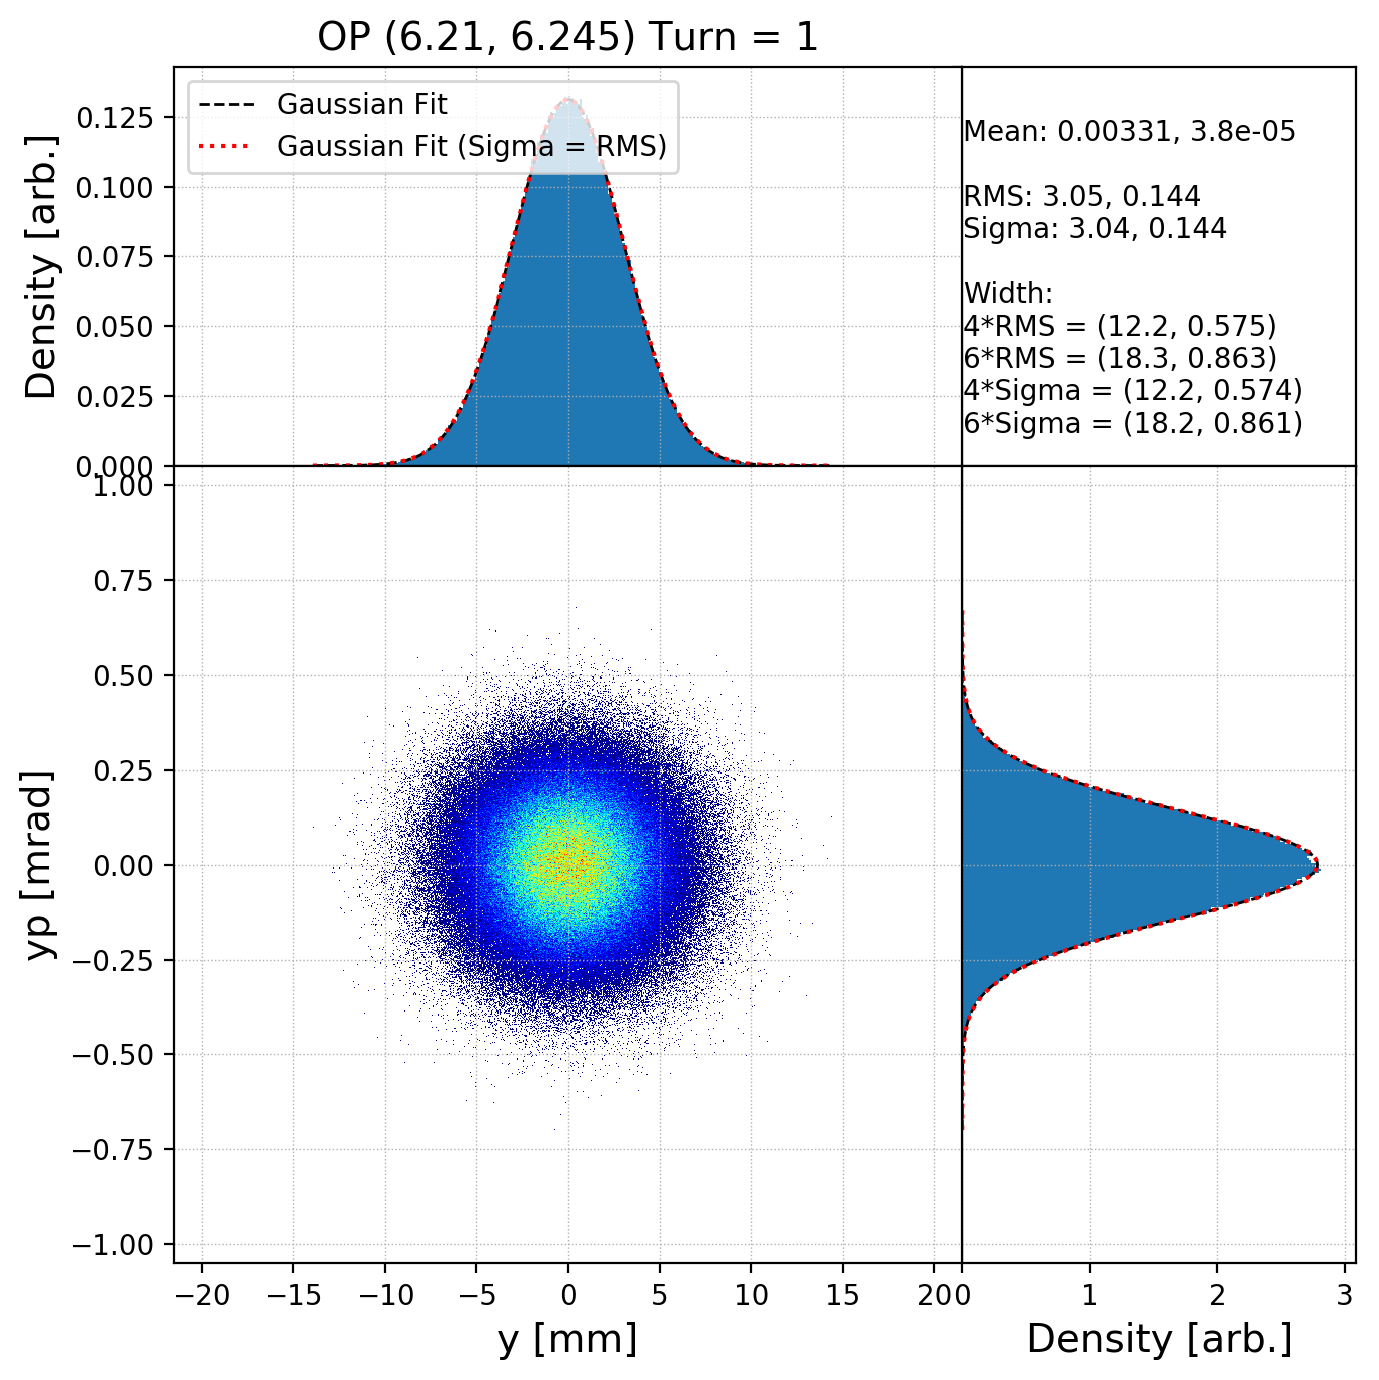

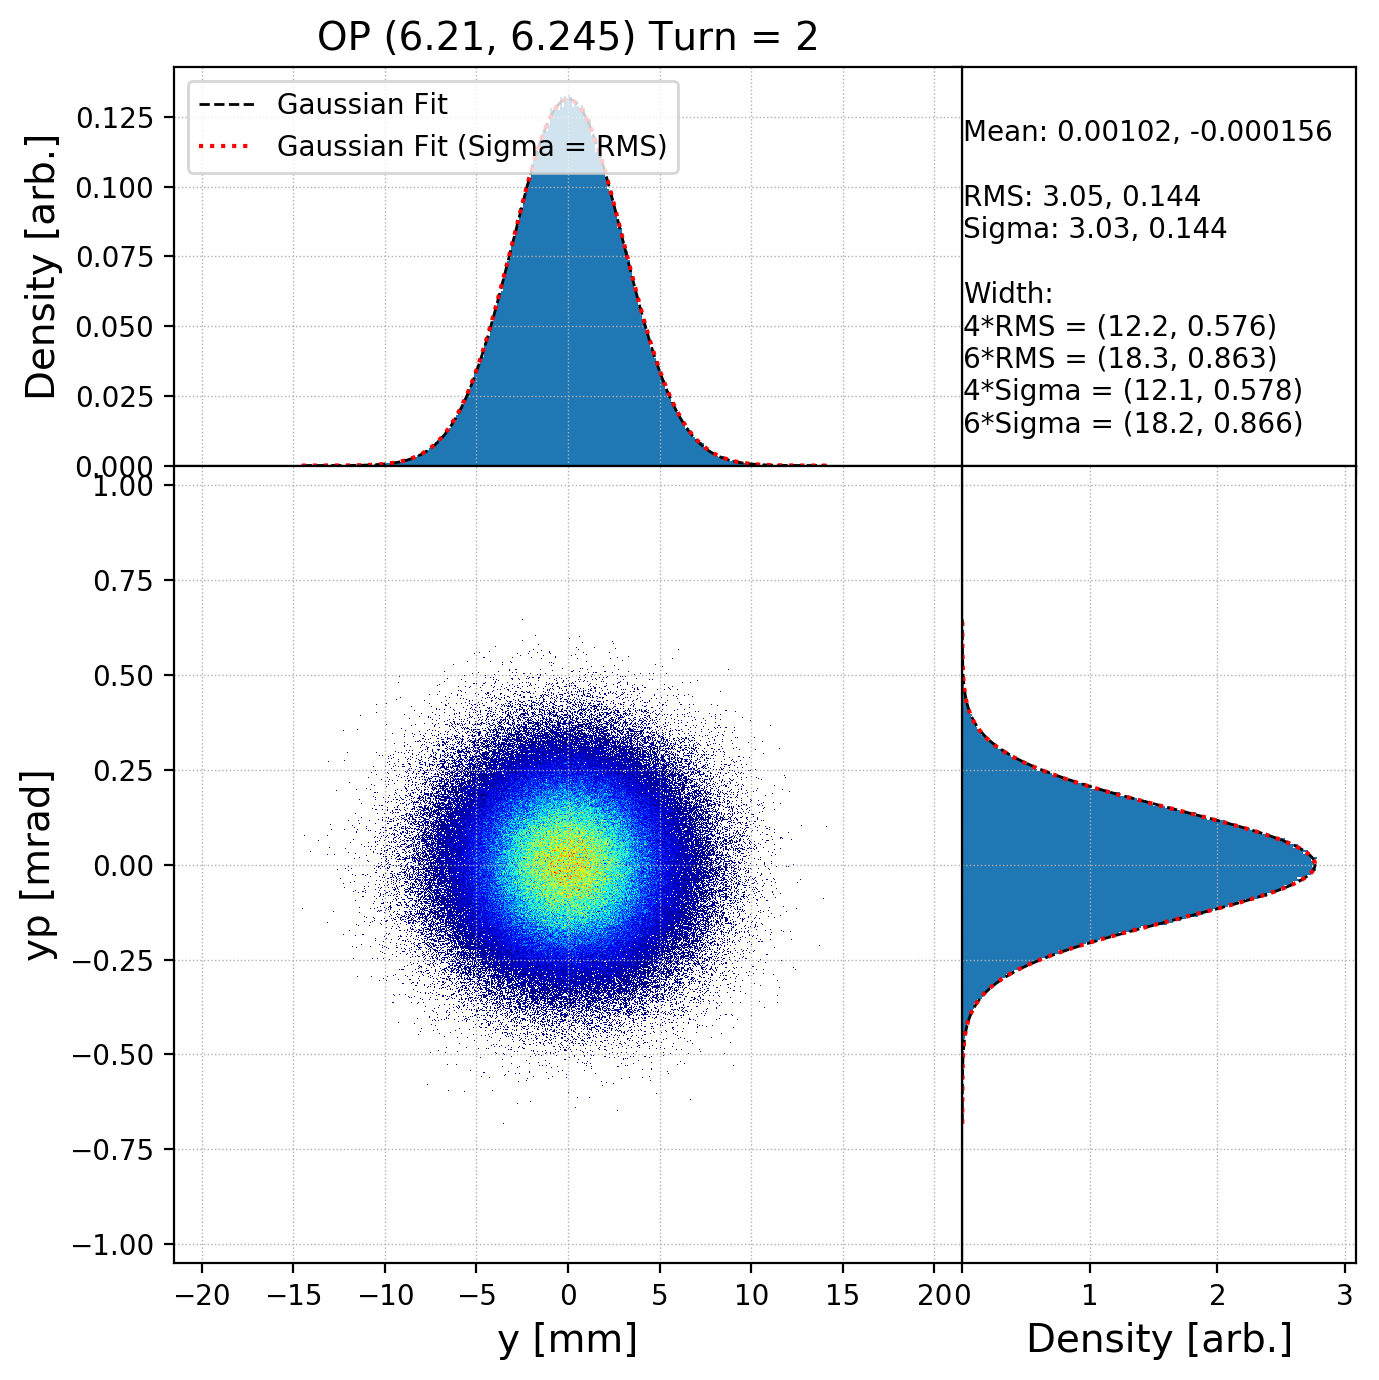

In [11]:
if YYP:    
#-----------------------------------------------------------------------  
# PLOT Y YP
#-----------------------------------------------------------------------    
    yyp_gifs =[]

    x_dat_lim = 1.
    y_dat_lim = 1.
    max_x_hist = 0.01
    max_y_hist = 0.01

    x_lab = 'y'
    y_lab = r'y$^{\prime}$'
    x_unit = 'mm'
    y_unit = 'mrad'

    first_turn = True
    first_turn_again = True


    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
        savename = str(save_folder + 'YYP_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:
                    
            print '\t YYP: Plotting ', main_label, ' ',x_lab,'-',y_lab, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
            
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            # ~ x  = particles.x * 1E3;
            # ~ xp = particles.xp* 1E3;
            # ~ y  = particles.y * 1E3;
            # ~ yp = particles.yp* 1E3;
            # ~ z  = particles.z * 1E9;
            # ~ dE = particles.dE;
            x_dat = particles.y * 1E3
            y_dat = particles.yp* 1E3
            

            my_cmap = plt.cm.jet
            my_cmap.set_under('w',1)

            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            
            fig = plt.figure(figsize=(7,7))
            gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
         
            # Calculate RMS Qx and Qy
            #-------------------------------------------------------------------
            x_dat_rms = np.sqrt(moment(x_dat,2))
            y_dat_rms = np.sqrt(moment(y_dat,2))
            x_dat_min = np.min(x_dat)
            x_dat_max = np.max(x_dat)
            y_dat_min = np.min(y_dat)
            y_dat_max = np.max(y_dat) 
            x_dat_4sig = 4 * x_dat_rms
            y_dat_4sig = 4 * y_dat_rms
            x_dat_6sig = 6 * x_dat_rms
            y_dat_6sig = 6 * y_dat_rms
            
            x_fine = np.arange(x_dat_min, x_dat_max, 1E-3)
            y_fine = np.arange(y_dat_min, y_dat_max, 1E-3)
            
            # TEXT BOX (top right)
            #-------------------------------------------------------------------
            ax4 = fig.add_subplot(gs[0, 2:3])
            ax4.set_yticklabels([])
            ax4.set_xticklabels([])
            
            # FIRST SUBPLOT - x histogram
            #-------------------------------------------------------------------
            ax1 = fig.add_subplot(gs[0, 0:2])
            ax1.set_title(title)    
            n_x, bins_x, patches_x = ax1.hist(x_dat, bins=master_bins/2, range=(np.min(x_dat), np.max(x_dat)), density=True)
            bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins
            
            if first_turn:
                x_dat_max = np.max(x_dat)
                x_dat_min = np.min(x_dat)       
                
                y_dat_max = np.max(y_dat)
                y_dat_min = np.min(y_dat)           
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round(-1*x_dat_min, 2) * 1.5
                else:
                    x_dat_lim = round(x_dat_max, 2) * 1.5     
                       
                if (-1*y_dat_min) > (y_dat_max):
                    y_dat_lim = round(-1*y_dat_min, 2) * 1.5
                else:
                    y_dat_lim = round(y_dat_max, 2) * 1.5        
                print '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim

                if np.max(n_x) > max_x_hist :
                    max_x_hist = round(np.max(n_x),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist
                first_turn = False

                    
            # fit Gaussian to histogram
            try:    
                amp_min_x = 0.99 * np.max(n_x)
                amp_max_x = 1.2 * np.max(n_x)
                if np.mean(x_dat) < 0:
                    mean_min_x = 1.05 * np.mean(x_dat)
                    mean_max_x = 0.95 * np.mean(x_dat)
                else:    
                    mean_min_x = 0.95 * np.mean(x_dat)
                    mean_max_x = 1.05 * np.mean(x_dat)                
                sig_min_x = 0.5 * x_dat_rms
                sig_max_x = 1.5 * x_dat_rms
                poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
                ax1.legend(loc=2)
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found'
                
            # ~ ax1.set_ylabel('Frequency')
            ax1.set_ylabel('Density [arb.]')    
            ax1.grid(which='both', ls=':', lw=0.5)
            ax1.set_ylim(0, max_x_hist)
            ax1.set_xlim(-1*x_dat_lim, x_dat_lim)
            
            # SECOND SUBPLOT - y histogram
            #-------------------------------------------------------------------
            ax3 = fig.add_subplot(gs[1:3, 2])
            n_y, bins_y, patches_y = ax3.hist(y_dat, bins=master_bins/2, range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
            bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

            if first_turn_again:
                if np.max(n_y) > max_y_hist :
                    max_y_hist = round(np.max(n_y),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist
                first_turn_again = False

            # fit Gaussian to histogram
            try:
                amp_min_y = 0.99 * np.max(n_y)
                amp_max_y = 1.2 * np.max(n_y)
                if np.mean(y_dat) < 0:
                    mean_min_y = 1.05 * np.mean(y_dat)
                    mean_max_y = 0.95 * np.mean(y_dat)
                else:    
                    mean_min_y = 0.95 * np.mean(y_dat)
                    mean_max_y = 1.05 * np.mean(y_dat)  
                sig_min_y = 0.5 * y_dat_rms
                sig_max_y = 1.5 * y_dat_rms
                popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
                ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
                ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', y_dat, ' Gaussian fit not found'
                
            # ~ ax3.set_xlabel('Frequency')    
            
            ax3.set_xlabel('Density [arb.]')    
            ax3.set_xlim(0, max_y_hist)
            ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax3.grid(which='both', ls=':', lw=0.5)
            
            # MAIN PLOT: TUNE FOOTPRINT
            #-------------------------------------------------------------------
            ax2 = fig.add_subplot(gs[1:3, 0:2])
            ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
            ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
            ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
            ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
            ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax2.grid(which='both', ls=':', lw=0.5)
            
            ax4txt = str(
                'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
                'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
                'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
                'Width:\n' +
                '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
                '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
                '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
                '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
                )
            ax4.text(0.001, 0.001, ax4txt, fontsize=10)
            
            plt.tight_layout()
            xy_gifs.append(savename)
            fig.savefig(savename)
            #plt.close(fig)

	 XXP: Plotting  OP   x - xp  scan tune = (6.21, 6.245)  turn =  1  with histograms

	  x - xp :  x  limit set to  18.42

	  x - xp :  xp  limit set to  1.41

	  x - xp : max_x_hist set to  0.165

	  x - xp : max_y_hist set to  2.321
	 XXP: Plotting  OP   x - xp  scan tune = (6.21, 6.245)  turn =  2  with histograms


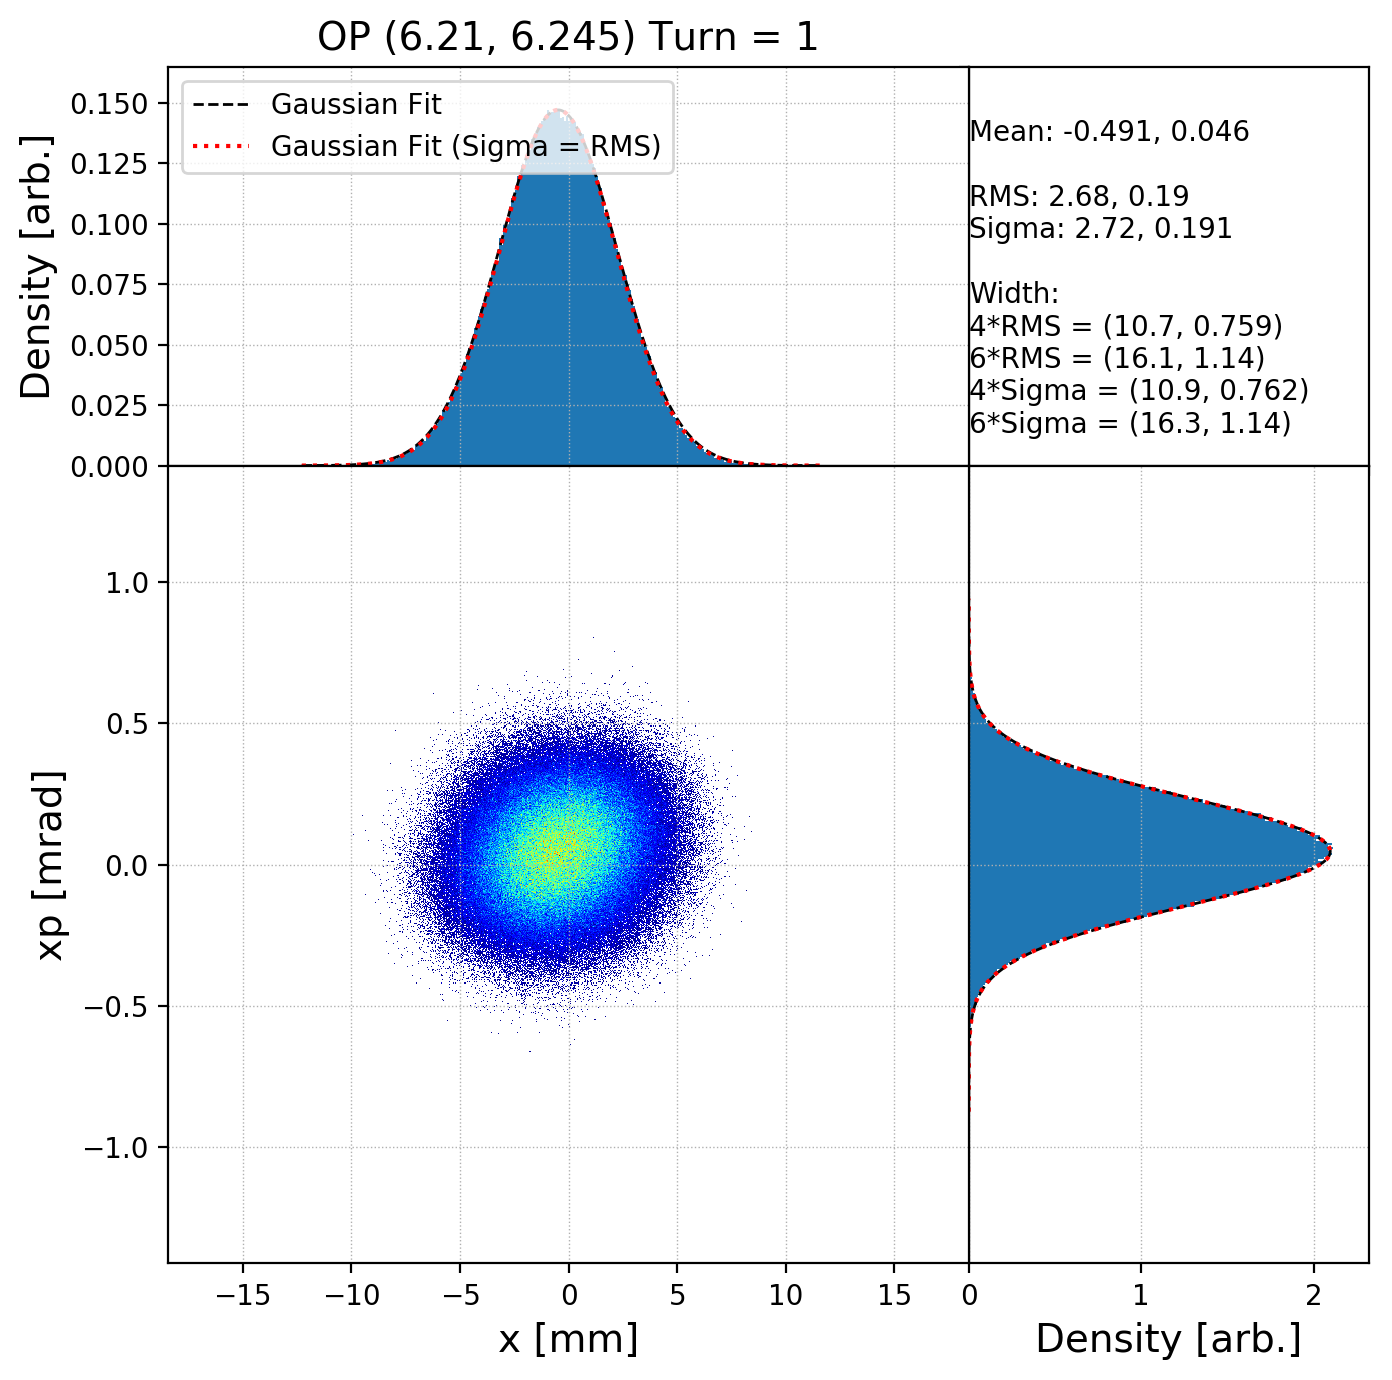

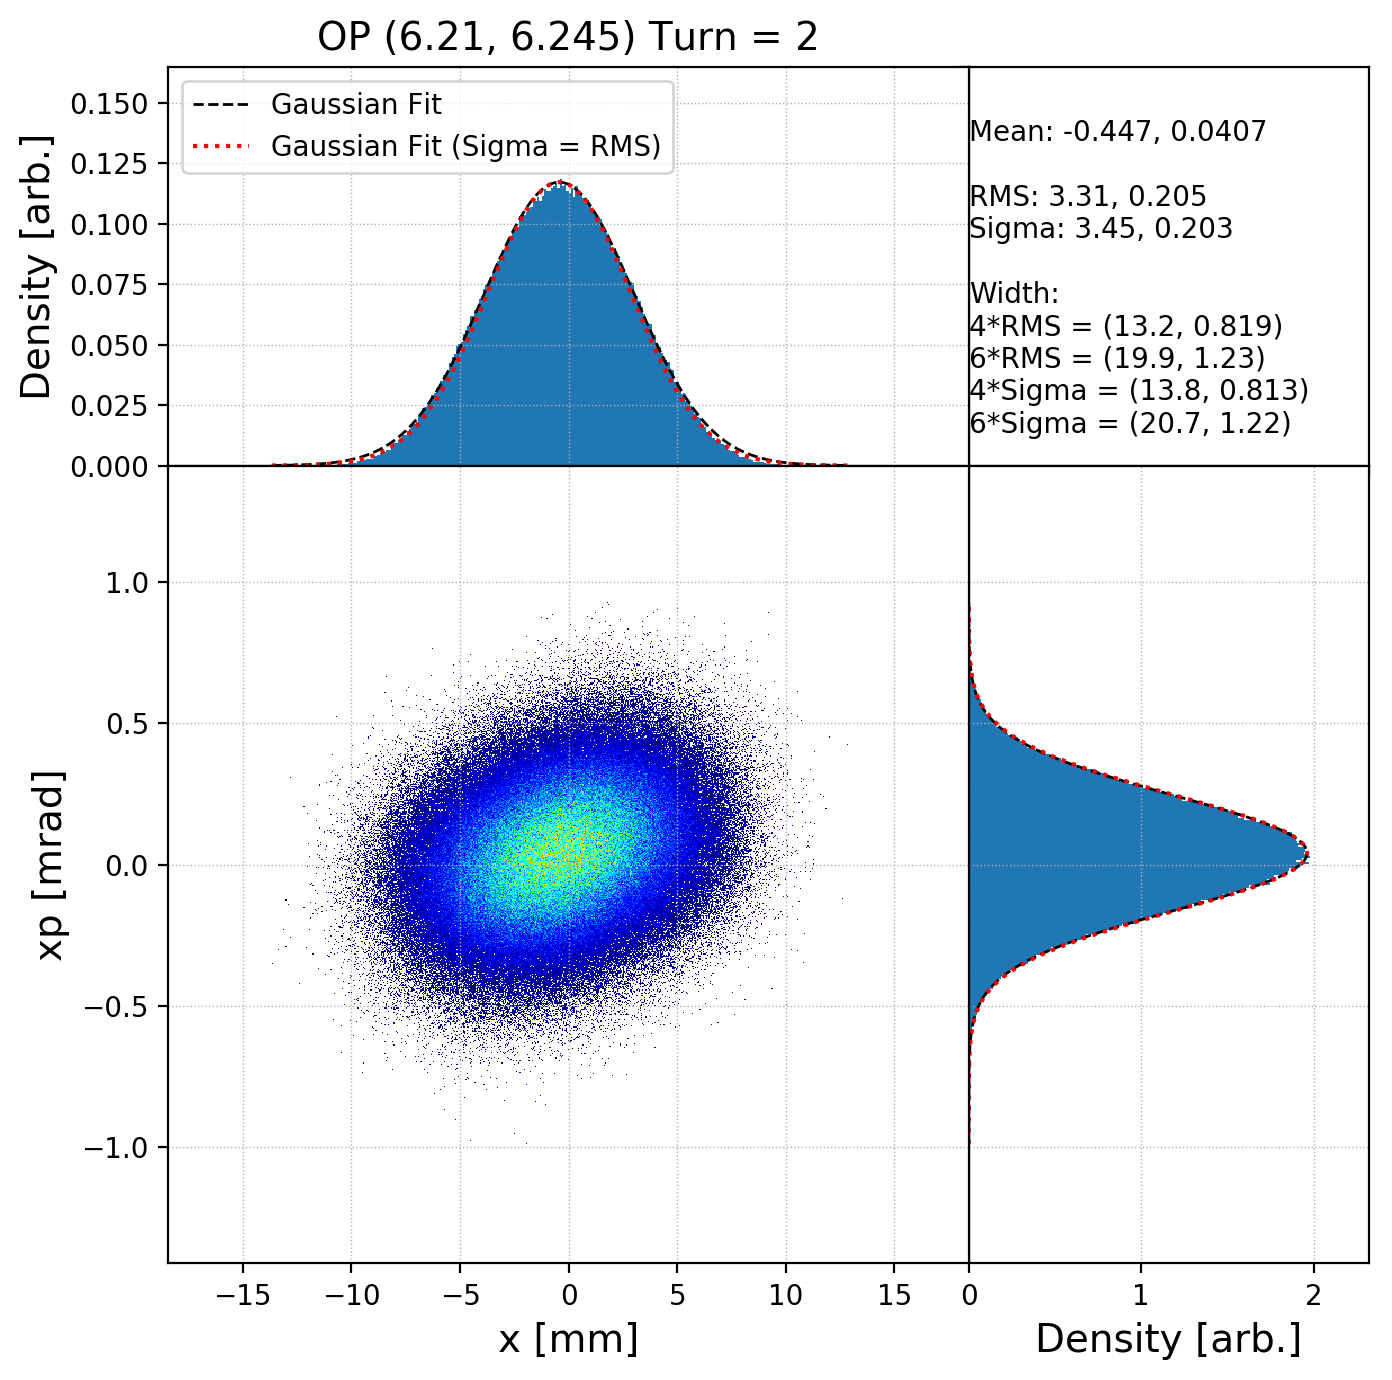

In [12]:

if XXP:
#-----------------------------------------------------------------------  
# PLOT X XP
#-----------------------------------------------------------------------    
    xxp_gifs =[]

    x_dat_lim = 1.
    y_dat_lim = 1.
    max_x_hist = 0.01
    max_y_hist = 0.01

    x_lab = 'x'
    y_lab = r'x$^{\prime}$'
    x_unit = 'mm'
    y_unit = 'mrad'

    first_turn = True
    first_turn_again = True

    # Loop over files
    #-----------------------------------------------------------------------
    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
        savename = str(save_folder + 'XXP_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:
                
            print '\t XXP: Plotting ', main_label, ' ',x_lab,'-',y_lab, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
            
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            # ~ x  = particles.x * 1E3;
            # ~ xp = particles.xp* 1E3;
            # ~ y  = particles.y * 1E3;
            # ~ yp = particles.yp* 1E3;
            # ~ z  = particles.z * 1E9;
            # ~ dE = particles.dE;
            x_dat = particles.x * 1E3
            y_dat = particles.xp* 1E3
            

            my_cmap = plt.cm.jet
            my_cmap.set_under('w',1)

            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            
            fig = plt.figure(figsize=(7,7))
            gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
         
            # Calculate RMS Qx and Qy
            #-------------------------------------------------------------------
            x_dat_rms = np.sqrt(moment(x_dat,2))
            y_dat_rms = np.sqrt(moment(y_dat,2))
            x_dat_min = np.min(x_dat)
            x_dat_max = np.max(x_dat)
            y_dat_min = np.min(y_dat)
            y_dat_max = np.max(y_dat) 
            x_dat_4sig = 4 * x_dat_rms
            y_dat_4sig = 4 * y_dat_rms
            x_dat_6sig = 6 * x_dat_rms
            y_dat_6sig = 6 * y_dat_rms
            
            x_fine = np.arange(x_dat_min, x_dat_max, 1E-3)
            y_fine = np.arange(y_dat_min, y_dat_max, 1E-3)
            
            # TEXT BOX (top right)
            #-------------------------------------------------------------------
            ax4 = fig.add_subplot(gs[0, 2:3])
            ax4.set_yticklabels([])
            ax4.set_xticklabels([])
            
            # FIRST SUBPLOT - x histogram
            #-------------------------------------------------------------------
            ax1 = fig.add_subplot(gs[0, 0:2])
            ax1.set_title(title)    
            n_x, bins_x, patches_x = ax1.hist(x_dat, bins=master_bins/2, range=(np.min(x_dat), np.max(x_dat)), density=True)
            bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins
            
            if first_turn:
                x_dat_max = np.max(x_dat)
                x_dat_min = np.min(x_dat)       
                
                y_dat_max = np.max(y_dat)
                y_dat_min = np.min(y_dat)           
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round(-1*x_dat_min, 2) * 1.5
                else:
                    x_dat_lim = round(x_dat_max, 2) * 1.5     
                       
                if (-1*y_dat_min) > (y_dat_max):
                    y_dat_lim = round(-1*y_dat_min, 2) * 1.5
                else:
                    y_dat_lim = round(y_dat_max, 2) * 1.5        
                print '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim

                if np.max(n_x) > max_x_hist :
                    max_x_hist = round(np.max(n_x),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist
                first_turn = False

                    
            # fit Gaussian to histogram
            try:    
                amp_min_x = 0.99 * np.max(n_x)
                amp_max_x = 1.2 * np.max(n_x)
                if np.mean(x_dat) < 0:
                    mean_min_x = 1.05 * np.mean(x_dat)
                    mean_max_x = 0.95 * np.mean(x_dat)
                else:    
                    mean_min_x = 0.95 * np.mean(x_dat)
                    mean_max_x = 1.05 * np.mean(x_dat)                
                sig_min_x = 0.5 * x_dat_rms
                sig_max_x = 1.5 * x_dat_rms
                poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
                ax1.legend(loc=2)
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found'
                
            # ~ ax1.set_ylabel('Frequency')
            ax1.set_ylabel('Density [arb.]')    
            ax1.grid(which='both', ls=':', lw=0.5)
            ax1.set_ylim(0, max_x_hist)
            ax1.set_xlim(-1*x_dat_lim, x_dat_lim)
            
            # SECOND SUBPLOT - y histogram
            #-------------------------------------------------------------------
            ax3 = fig.add_subplot(gs[1:3, 2])
            n_y, bins_y, patches_y = ax3.hist(y_dat, bins=master_bins/2, range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
            bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

            if first_turn_again:
                if np.max(n_y) > max_y_hist :
                    max_y_hist = round(np.max(n_y),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist
                first_turn_again = False

            # fit Gaussian to histogram
            try:
                amp_min_y = 0.99 * np.max(n_y)
                amp_max_y = 1.2 * np.max(n_y)
                if np.mean(y_dat) < 0:
                    mean_min_y = 1.05 * np.mean(y_dat)
                    mean_max_y = 0.95 * np.mean(y_dat)
                else:    
                    mean_min_y = 0.95 * np.mean(y_dat)
                    mean_max_y = 1.05 * np.mean(y_dat)  
                sig_min_y = 0.5 * y_dat_rms
                sig_max_y = 1.5 * y_dat_rms
                popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
                ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
                ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', y_dat, ' Gaussian fit not found'
                
            # ~ ax3.set_xlabel('Frequency')    
            
            ax3.set_xlabel('Density [arb.]')    
            ax3.set_xlim(0, max_y_hist)
            ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax3.grid(which='both', ls=':', lw=0.5)
            
            # MAIN PLOT: TUNE FOOTPRINT
            #-------------------------------------------------------------------
            ax2 = fig.add_subplot(gs[1:3, 0:2])
            ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
            ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
            ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
            ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
            ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax2.grid(which='both', ls=':', lw=0.5)
            
            ax4txt = str(
                'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
                'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
                'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
                'Width:\n' +
                '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
                '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
                '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
                '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
                )
            ax4.text(0.001, 0.001, ax4txt, fontsize=10)
            
            plt.tight_layout()
            xy_gifs.append(savename)
            fig.savefig(savename)
            #plt.close(fig)


	 ZDE: Plotting  OP   z - dE  scan tune = (6.21, 6.245)  turn =  1  with histograms

	  z - dE :  z  limit set to  30.6

	  z - dE :  dE  limit set to  5.49

	  z - dE : max_x_hist set to  0.044

	  z - dE : max_y_hist set to  0.22
	 ZDE: Plotting  OP   z - dE  scan tune = (6.21, 6.245)  turn =  2  with histograms


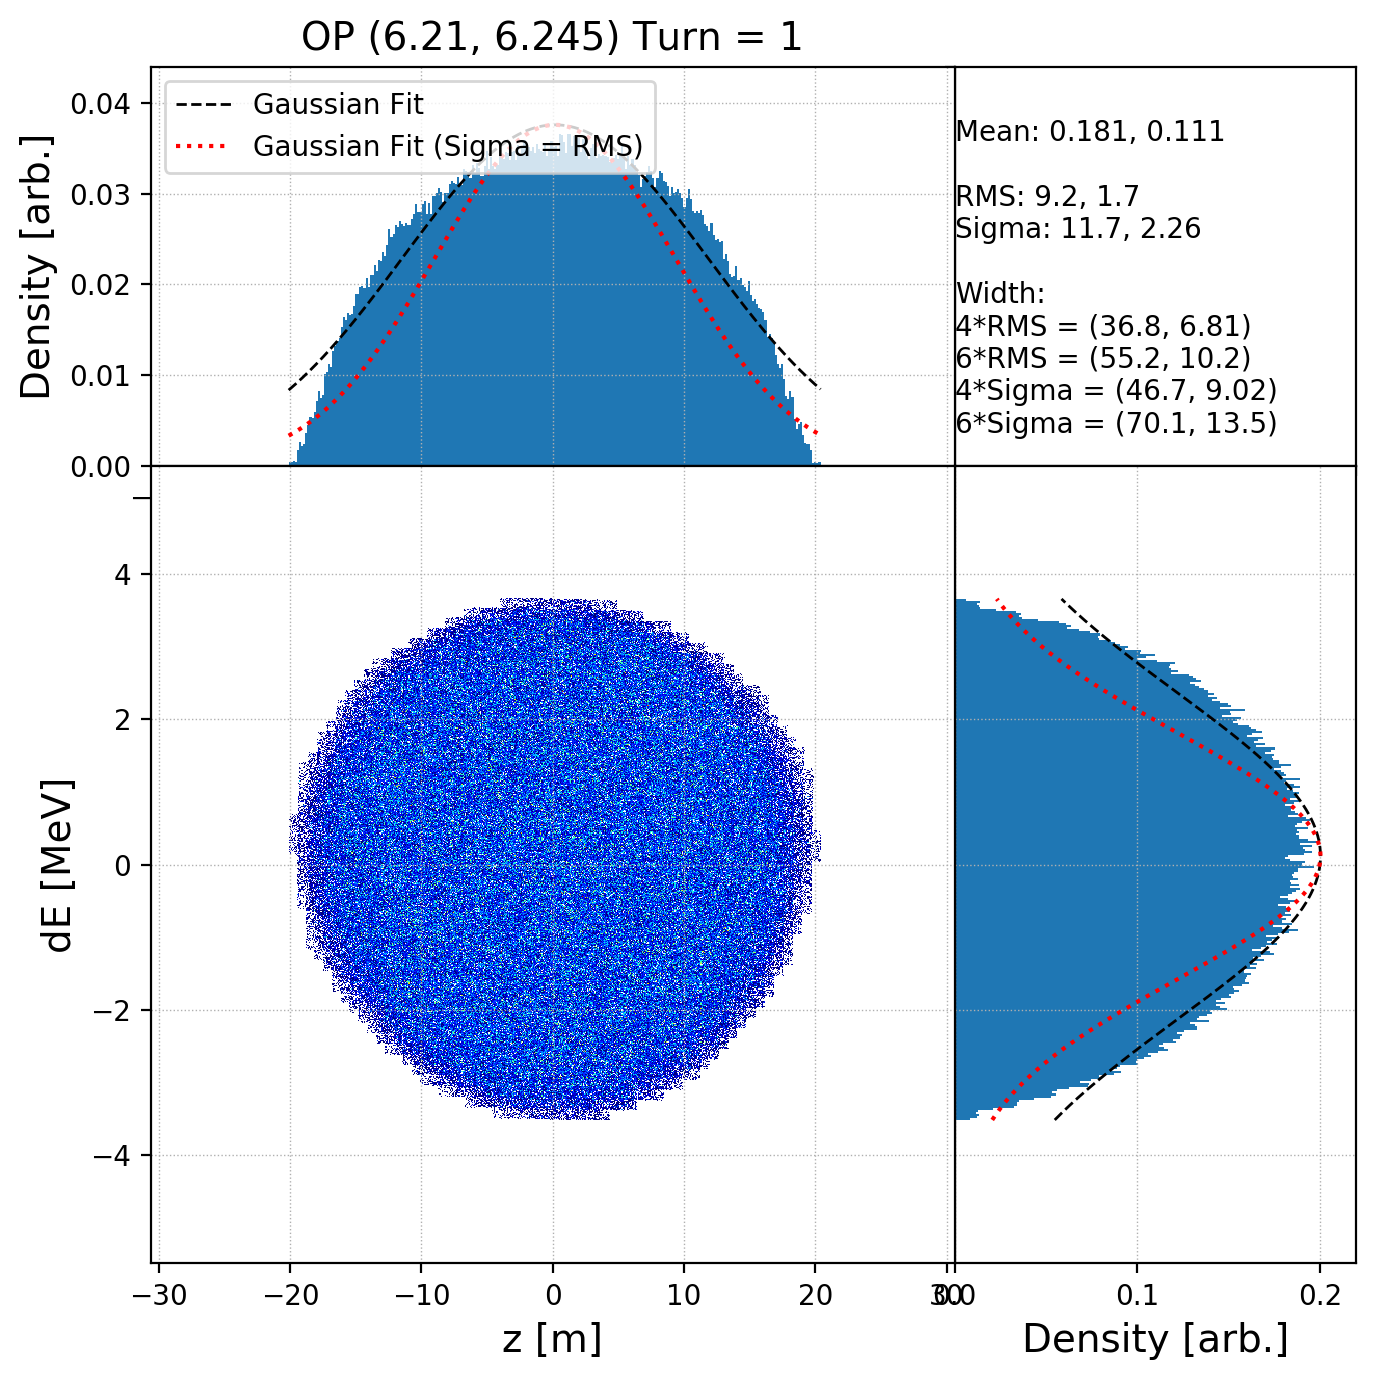

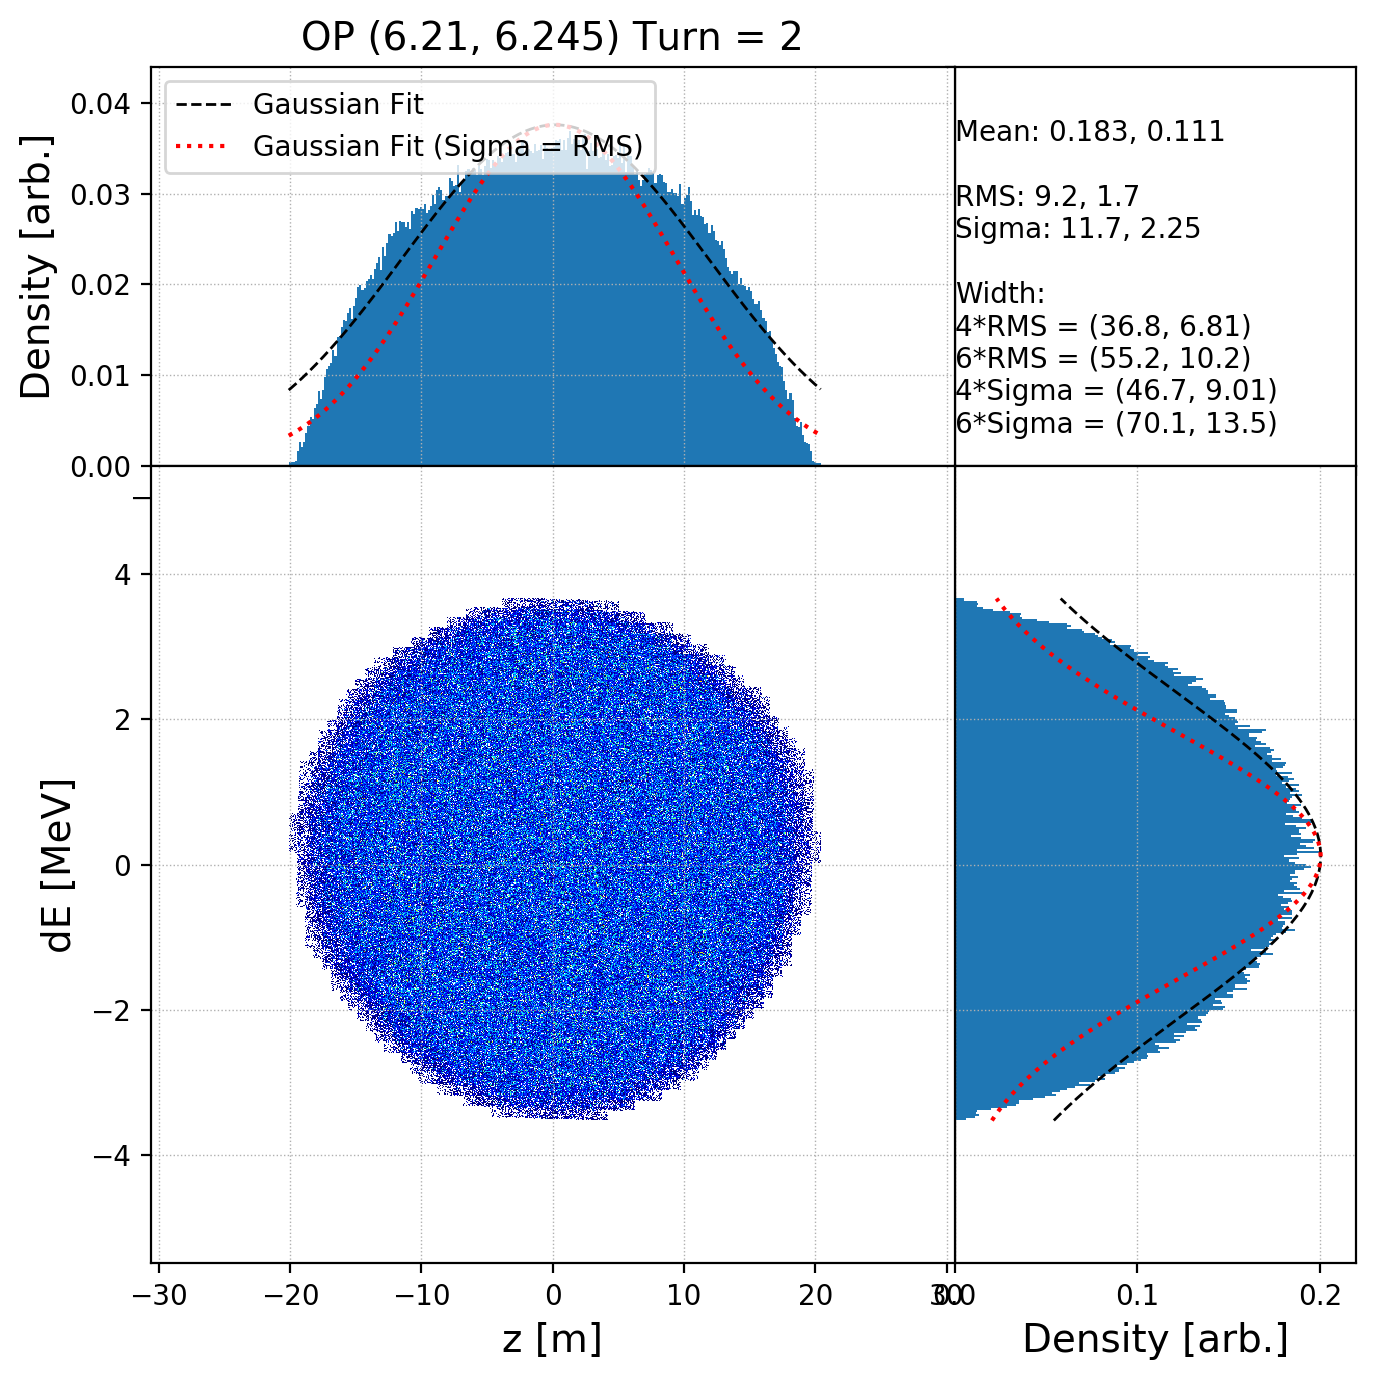

In [16]:
if ZDE:
#-----------------------------------------------------------------------  
# PLOT Z dE
#-----------------------------------------------------------------------    
    zdE_gifs =[]

    x_dat_lim = 1.
    y_dat_lim = 1.
    max_x_hist = 0.01
    max_y_hist = 0.01

    x_lab = 'z'
    y_lab = 'dE'
    x_unit = 'm'
    y_unit = 'MeV'

    first_turn = True
    first_turn_again = True

    # Loop over files
    #-----------------------------------------------------------------------
    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
            
        savename = str(save_folder + 'ZDE_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:     
                
            print '\t ZDE: Plotting ', main_label, ' ',x_lab,'-',y_lab, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
            
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            # ~ x  = particles.x * 1E3;
            # ~ xp = particles.xp* 1E3;
            # ~ y  = particles.y * 1E3;
            # ~ yp = particles.yp* 1E3;
            # ~ z  = particles.z * 1E9;
            # ~ dE = particles.dE;
            x_dat = particles.z;
            y_dat = particles.dE * 1E3;
            

            my_cmap = plt.cm.jet
            my_cmap.set_under('w',1)

            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            
            fig = plt.figure(figsize=(7,7))
            gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
         
            # Calculate RMS Qx and Qy
            #-------------------------------------------------------------------
            x_dat_rms = np.sqrt(moment(x_dat,2))
            y_dat_rms = np.sqrt(moment(y_dat,2))
            x_dat_min = np.min(x_dat)
            x_dat_max = np.max(x_dat)
            y_dat_min = np.min(y_dat)
            y_dat_max = np.max(y_dat) 
            x_dat_4sig = 4 * x_dat_rms
            y_dat_4sig = 4 * y_dat_rms
            x_dat_6sig = 6 * x_dat_rms
            y_dat_6sig = 6 * y_dat_rms
            
            x_fine = np.arange(x_dat_min, x_dat_max, 1E-3)
            y_fine = np.arange(y_dat_min, y_dat_max, 1E-3)
            
            # TEXT BOX (top right)
            #-------------------------------------------------------------------
            ax4 = fig.add_subplot(gs[0, 2:3])
            ax4.set_yticklabels([])
            ax4.set_xticklabels([])
            
            # FIRST SUBPLOT - x histogram
            #-------------------------------------------------------------------
            ax1 = fig.add_subplot(gs[0, 0:2])
            ax1.set_title(title)    
            n_x, bins_x, patches_x = ax1.hist(x_dat, bins=master_bins/2, range=(np.min(x_dat), np.max(x_dat)), density=True)
            bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins
            
            if first_turn:
                x_dat_max = np.max(x_dat)
                x_dat_min = np.min(x_dat)       
                
                y_dat_max = np.max(y_dat)
                y_dat_min = np.min(y_dat)           
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round(-1*x_dat_min, 2) * 1.5
                else:
                    x_dat_lim = round(x_dat_max, 2) * 1.5     
                       
                if (-1*y_dat_min) > (y_dat_max):
                    y_dat_lim = round(-1*y_dat_min, 2) * 1.5
                else:
                    y_dat_lim = round(y_dat_max, 2) * 1.5        
                print '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim

                if np.max(n_x) > max_x_hist :
                    max_x_hist = round(np.max(n_x),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist
                first_turn = False

                    
            # fit Gaussian to histogram
            try:    
                amp_min_x = 0.99 * np.max(n_x)
                amp_max_x = 1.2 * np.max(n_x)
                if np.mean(x_dat) < 0:
                    mean_min_x = 1.05 * np.mean(x_dat)
                    mean_max_x = 0.95 * np.mean(x_dat)
                else:    
                    mean_min_x = 0.95 * np.mean(x_dat)
                    mean_max_x = 1.05 * np.mean(x_dat)                
                sig_min_x = 0.5 * x_dat_rms
                sig_max_x = 1.5 * x_dat_rms
                poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
                ax1.legend(loc=2)
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found'
                
            # ~ ax1.set_ylabel('Frequency')
            ax1.set_ylabel('Density [arb.]')    
            ax1.grid(which='both', ls=':', lw=0.5)
            ax1.set_ylim(0, max_x_hist)
            ax1.set_xlim(-1*x_dat_lim, x_dat_lim)
            
            # SECOND SUBPLOT - y histogram
            #-------------------------------------------------------------------
            ax3 = fig.add_subplot(gs[1:3, 2])
            n_y, bins_y, patches_y = ax3.hist(y_dat, bins=master_bins/2, range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
            bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

            if first_turn_again:
                if np.max(n_y) > max_y_hist :
                    max_y_hist = round(np.max(n_y),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist
                first_turn_again = False

            # fit Gaussian to histogram
            try:
                amp_min_y = 0.99 * np.max(n_y)
                amp_max_y = 1.2 * np.max(n_y)
                if np.mean(y_dat) < 0:
                    mean_min_y = 1.05 * np.mean(y_dat)
                    mean_max_y = 0.95 * np.mean(y_dat)
                else:    
                    mean_min_y = 0.95 * np.mean(y_dat)
                    mean_max_y = 1.05 * np.mean(y_dat)  
                sig_min_y = 0.5 * y_dat_rms
                sig_max_y = 1.5 * y_dat_rms
                popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
                ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
                ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', y_dat, ' Gaussian fit not found'
                
            # ~ ax3.set_xlabel('Frequency')    
            
            ax3.set_xlabel('Density [arb.]')    
            ax3.set_xlim(0, max_y_hist)
            ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax3.grid(which='both', ls=':', lw=0.5)
            
            # MAIN PLOT: TUNE FOOTPRINT
            #-------------------------------------------------------------------
            ax2 = fig.add_subplot(gs[1:3, 0:2])
            ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
            ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
            ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
            ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
            ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax2.grid(which='both', ls=':', lw=0.5)
            
            ax4txt = str(
                'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
                'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
                'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
                'Width:\n' +
                '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
                '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
                '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
                '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
                )
            ax4.text(0.001, 0.001, ax4txt, fontsize=10)
            
            plt.tight_layout()
            xy_gifs.append(savename)
            fig.savefig(savename)
            #plt.close(fig)
 

	 T DPP: Plotting  OP   t - dpp  scan tune = (6.21, 6.245)  turn =  1  with histograms

	  t - dpp :  t  limit set to  111.45

	  t - dpp :  dpp  limit set to  2.805

	  t - dpp : max_x_hist set to  0.011

	  t - dpp : max_y_hist set to  0.429
	 T DPP: Plotting  OP   t - dpp  scan tune = (6.21, 6.245)  turn =  2  with histograms


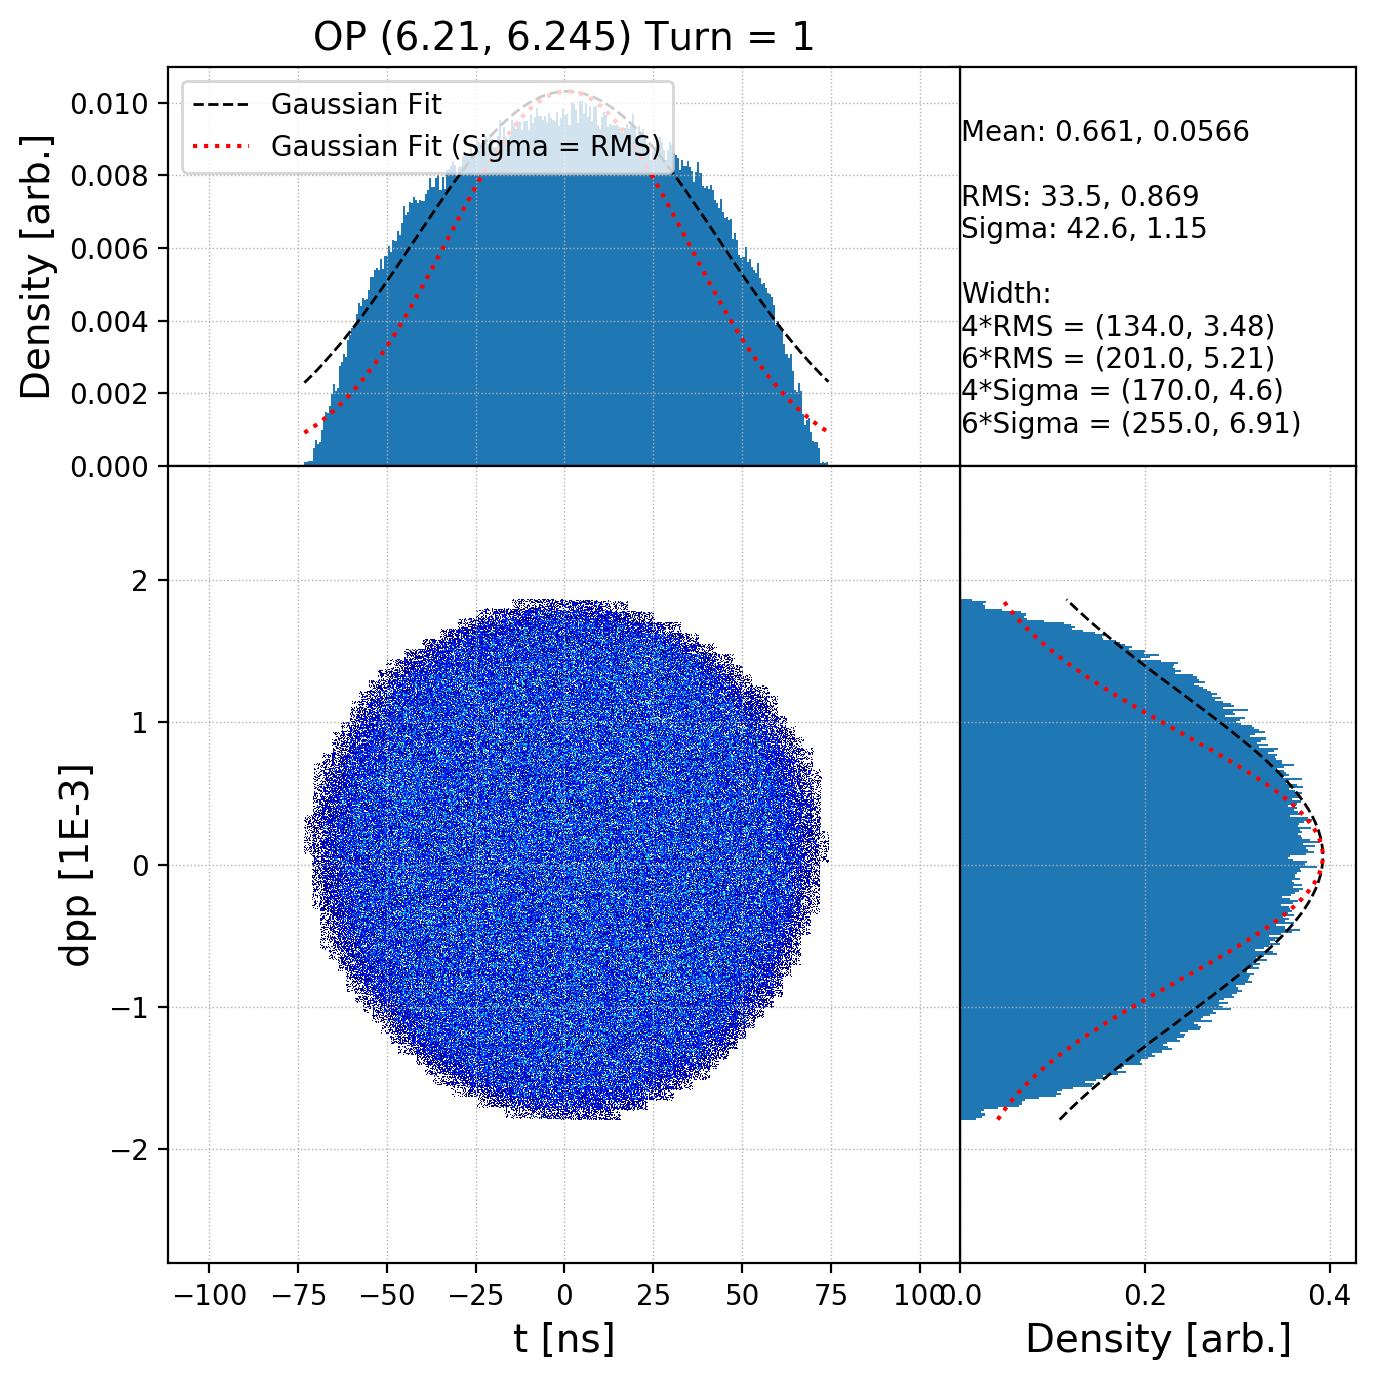

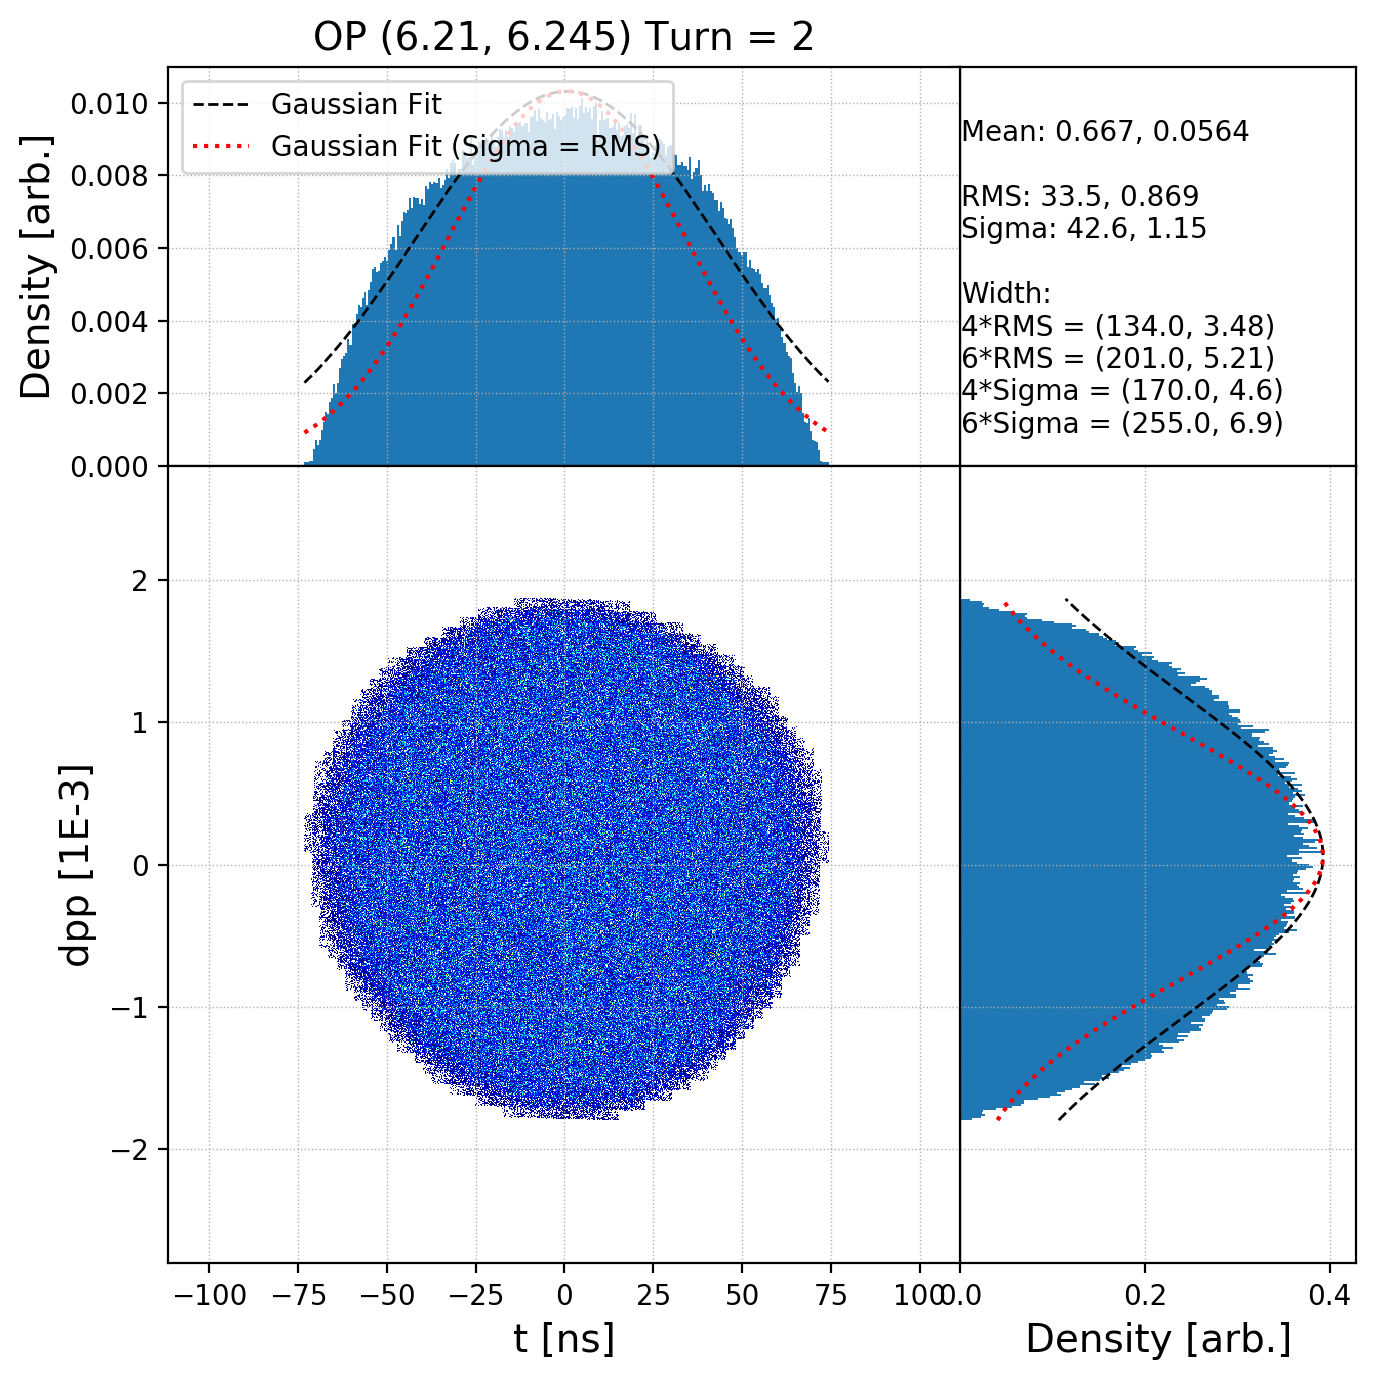

In [14]:
if TDPP:
#-----------------------------------------------------------------------  
# PLOT t dp
#-----------------------------------------------------------------------    
    zdE_gifs =[]

    x_dat_lim = 50
    y_dat_lim = 1E-3
    max_x_hist = 0.01
    max_y_hist = 0.01

    x_lab = 't'
    y_lab = r'$\frac{\delta p}{p}$'
    x_unit = 'ns'
    y_unit = '1E-3'

    first_turn = True
    first_turn_again = True

    # Loop over files
    #-----------------------------------------------------------------------
    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
            
        savename = str(save_folder + '/TDPP_' + tune_sav + '_turn_' + str(turn) + '.png' )
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:     
                
            print '\t T DPP: Plotting ', main_label, ' ',x_lab,'-',y_lab, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
            
            # Load data 
            #-------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            # ~ x  = particles.x * 1E3;
            # ~ xp = particles.xp* 1E3;
            # ~ y  = particles.y * 1E3;
            # ~ yp = particles.yp* 1E3;
            # ~ z  = particles.z * 1E9;
            # ~ dE = particles.dE;
            x_dat = z_to_time(particles.z, lorentz_gamma)*1E9;
            y_dat = dpp_from_dE(particles.dE, lorentz_gamma)*1E3;

            my_cmap = plt.cm.jet
            my_cmap.set_under('w',1)

            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            
            fig = plt.figure(figsize=(7,7))
            gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
         
            # Calculate RMS Qx and Qy
            #-------------------------------------------------------------------
            x_dat_rms = np.sqrt(moment(x_dat,2))
            y_dat_rms = np.sqrt(moment(y_dat,2))
            x_dat_min = np.min(x_dat)
            x_dat_max = np.max(x_dat)
            y_dat_min = np.min(y_dat)
            y_dat_max = np.max(y_dat) 
            x_dat_4sig = 4 * x_dat_rms
            y_dat_4sig = 4 * y_dat_rms
            x_dat_6sig = 6 * x_dat_rms
            y_dat_6sig = 6 * y_dat_rms
            
            x_fine = np.arange(x_dat_min, x_dat_max, 1E-3)
            y_fine = np.arange(y_dat_min, y_dat_max, 1E-3)
            
            # TEXT BOX (top right)
            #-------------------------------------------------------------------
            ax4 = fig.add_subplot(gs[0, 2:3])
            ax4.set_yticklabels([])
            ax4.set_xticklabels([])
            
            # FIRST SUBPLOT - x histogram
            #-------------------------------------------------------------------
            ax1 = fig.add_subplot(gs[0, 0:2])
            ax1.set_title(title)    
            n_x, bins_x, patches_x = ax1.hist(x_dat, bins=master_bins/2, range=(np.min(x_dat), np.max(x_dat)), density=True)
            bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins
            
            if first_turn:
                x_dat_max = np.max(x_dat)
                x_dat_min = np.min(x_dat)       
                
                y_dat_max = np.max(y_dat)
                y_dat_min = np.min(y_dat)           
                 
                if (-1*x_dat_min) > (x_dat_max):
                    x_dat_lim = round(-1*x_dat_min, 2) * 1.5
                else:
                    x_dat_lim = round(x_dat_max, 2) * 1.5     
                       
                if (-1*y_dat_min) > (y_dat_max):
                    y_dat_lim = round(-1*y_dat_min, 2) * 1.5
                else:
                    y_dat_lim = round(y_dat_max, 2) * 1.5        
                print '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim
                print '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim

                if np.max(n_x) > max_x_hist :
                    max_x_hist = round(np.max(n_x),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist
                first_turn = False

                    
            # fit Gaussian to histogram
            try:    
                amp_min_x = 0.99 * np.max(n_x)
                amp_max_x = 1.2 * np.max(n_x)
                if np.mean(x_dat) < 0:
                    mean_min_x = 1.05 * np.mean(x_dat)
                    mean_max_x = 0.95 * np.mean(x_dat)
                else:    
                    mean_min_x = 0.95 * np.mean(x_dat)
                    mean_max_x = 1.05 * np.mean(x_dat)                
                sig_min_x = 0.5 * x_dat_rms
                sig_max_x = 1.5 * x_dat_rms
                poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
                ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
                ax1.legend(loc=2)
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found'
                
            # ~ ax1.set_ylabel('Frequency')
            ax1.set_ylabel('Density [arb.]')    
            ax1.grid(which='both', ls=':', lw=0.5)
            ax1.set_ylim(0, max_x_hist)
            ax1.set_xlim(-1*x_dat_lim, x_dat_lim)
            
            # SECOND SUBPLOT - y histogram
            #-------------------------------------------------------------------
            ax3 = fig.add_subplot(gs[1:3, 2])
            n_y, bins_y, patches_y = ax3.hist(y_dat, bins=master_bins/2, range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
            bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

            if first_turn_again:
                if np.max(n_y) > max_y_hist :
                    max_y_hist = round(np.max(n_y),2) * 1.1
                    print '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist
                first_turn_again = False

            # fit Gaussian to histogram
            try:
                amp_min_y = 0.99 * np.max(n_y)
                amp_max_y = 1.2 * np.max(n_y)
                if np.mean(y_dat) < 0:
                    mean_min_y = 1.05 * np.mean(y_dat)
                    mean_max_y = 0.95 * np.mean(y_dat)
                else:    
                    mean_min_y = 0.95 * np.mean(y_dat)
                    mean_max_y = 1.05 * np.mean(y_dat)  
                sig_min_y = 0.5 * y_dat_rms
                sig_max_y = 1.5 * y_dat_rms
                popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
                ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
                ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', y_dat, ' Gaussian fit not found'
                
            # ~ ax3.set_xlabel('Frequency')    
            
            ax3.set_xlabel('Density [arb.]')    
            ax3.set_xlim(0, max_y_hist)
            ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax3.grid(which='both', ls=':', lw=0.5)
            
            # MAIN PLOT: TUNE FOOTPRINT
            #-------------------------------------------------------------------
            ax2 = fig.add_subplot(gs[1:3, 0:2])
            ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
            ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
            ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
            ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
            ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
            ax2.grid(which='both', ls=':', lw=0.5)
            
            ax4txt = str(
                'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
                'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
                'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
                'Width:\n' +
                '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
                '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
                '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
                '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
                )
            ax4.text(0.001, 0.001, ax4txt, fontsize=10)
            
            plt.tight_layout()
            xy_gifs.append(savename)
            fig.savefig(savename)
            #plt.close(fig)


In [17]:
if TUNE:
        
    # Remove first two turns before plotting tunespread
    #-----------------------------------------------------------------------
    for i, file in enumerate(files):
        if 'mainbunch_-000001.mat' in file:
            files.remove(file)
    for i, file in enumerate(files):
        if 'mainbunch_000000.mat' in file:
            files.remove(file)

    #-----------------------------------------------------------------------  
    # PLOT TUNE
    #-----------------------------------------------------------------------    
    tune_gifs = []

    max_1d_hist = 10

    integer_tune_x = 6.
    integer_tune_y = 6.
    min_tune = 5.75
    max_tune = 6.25
    q_fine = np.arange(5.5, 6.51, 0.01)

    first_turn = True

    # Loop over files
    #-----------------------------------------------------------------------
    for i, file in enumerate(files):
        folder = file.split('/')[0] + '/' + file.split('/')[1]
        try: 
            turn = int(file.split('mainbunch_')[-1][:-4])
        except:
            turn = ''
            
        savename = str(save_folder + '/Tune_Footprint_' + tune_sav + '_turn_' + str(turn) + '.png' );
        file_exists = check_if_fig_exists(savename)
        
        if not file_exists:

            print '\t TUNE: Plotting ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
            
            # Load data 
            #------------------------------------------------------------------------------
            particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
            qx = particles.ParticlePhaseAttributes[2,:]
            qy = particles.ParticlePhaseAttributes[3,:]
            qx[np.where(qx>0.5)] -= 1
            qy[np.where((qy>0.6) & (qx<0.25))] -= 1 
             
            my_cmap = plt.cm.jet
            my_cmap.set_under('w',1)

            title = str( main_label + ' ' + tune_tit + ' Turn = ' + str(turn) )    
            
            fig = plt.figure(figsize=(7,7))
            gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
            r = resonance_lines((min_tune, max_tune),(min_tune, max_tune),(1,2,3,4),10)
         
            # Calculate RMS Qx and Qy
            #------------------------------------------------------------------------------
            Q_x_rms = np.sqrt(moment(6+qx,2))
            Q_y_rms = np.sqrt(moment(6+qy,2))
            Q_x_min = np.min(6+qx)
            Q_x_max = np.max(6+qx)
            Q_y_min = np.min(6+qy)
            Q_y_max = np.max(6+qy)
            Delta_q_x = Q_x_max - Q_x_min
            Delta_q_y = Q_y_max - Q_y_min    
            Delta_q_x_4sig = 4 * Q_x_rms
            Delta_q_y_4sig = 4 * Q_y_rms
            Delta_q_x_6sig = 6 * Q_x_rms
            Delta_q_y_6sig = 6 * Q_y_rms
            
            # TEXT BOX (top right)
            #------------------------------------------------------------------------------
            ax4 = fig.add_subplot(gs[0, 2:3])
            ax4.set_yticklabels([])
            ax4.set_xticklabels([])
            
            # FIRST SUBPLOT - x histogram
            #------------------------------------------------------------------------------
            ax1 = fig.add_subplot(gs[0, 0:2])
            ax1.set_title(title)    
            n_x, bins_x, patches_x = ax1.hist(integer_tune_x+qx, bins=master_bins, range=(r.Qx_min, r.Qx_max), density=True)
            bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins

            if first_turn:
                if np.max(n_x) > max_1d_hist :
                    max_1d_hist = round(np.max(n_x),2) + 2
                    print '\n\t TUNE: max_1d_hist set to ', max_1d_hist
                    first_turn = False
                    
            # fit Gaussian to histogram
            try:    
                amp_min_x = 0.99 * np.max(n_x)
                amp_max_x = 1.2 * np.max(n_x)
                if bins_x[np.argmax(n_x)] < 0:
                    mean_min_x = 1.1 * (bins_x[np.argmax(n_x)])
                    mean_max_x = 0.9 * (bins_x[np.argmax(n_x)])
                else:    
                    mean_min_x = 0.9 * (bins_x[np.argmax(n_x)])
                    mean_max_x = 1.1 * (bins_x[np.argmax(n_x)])
                sig_min_x = 0.5 * Q_x_rms
                sig_max_x = 1.5 * Q_x_rms
                poptx, pcovx = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
                ax1.plot(q_fine, gaussian(q_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
                ax1.plot(q_fine, gaussian(q_fine, poptx[0], poptx[1], Q_x_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
                ax1.legend(loc=2)
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' q_x Gaussian fit not found'
                
            # ~ ax1.set_ylabel('Frequency')
            ax1.set_ylabel('Density [arb.]')
            ax1.grid(which='both', ls=':', lw=0.5)
            ax1.set_ylim(0, max_1d_hist)
            ax1.set_xlim(min_tune, max_tune)
            
            # SECOND SUBPLOT - y histogram
            #------------------------------------------------------------------------------
            ax3 = fig.add_subplot(gs[1:3, 2])
            n_y, bins_y, patches_y = ax3.hist(integer_tune_y+qy, bins=master_bins, range=(r.Qy_min, r.Qy_max), orientation=u'horizontal', density=True)
            bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

            # fit Gaussian to histogram
            try:
                amp_min_y = 0.99 * np.max(n_y)
                amp_max_y = 1.2 * np.max(n_y)
                if bins_y[np.argmax(n_y)] < 0:
                    mean_min_y = 1.1 * (bins_y[np.argmax(n_y)])
                    mean_max_y = 0.9 * (bins_y[np.argmax(n_y)])
                else:    
                    mean_min_y = 0.9 * (bins_y[np.argmax(n_y)])
                    mean_max_y = 1.1 * (bins_y[np.argmax(n_y)])
                sig_min_y = 0.5 * Q_y_rms
                sig_max_y = 1.5 * Q_y_rms
                popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
                ax3.plot(gaussian(q_fine, popty[0], popty[1], popty[2]), q_fine, 'k--', lw=1, label='Gaussian Fit')
                ax3.plot(gaussian(q_fine, popty[0], popty[1], Q_y_rms), q_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
            except RuntimeError:
                print '\n\t TUNE: RuntimeError ', main_label, ' scan tune =', tune_tit, ' turn = ', turn, ' q_y Gaussian fit not found'
                
            # ~ ax3.set_xlabel('Frequency')    
            ax3.set_xlabel('Density [arb.]')    
            ax3.set_xlim(0, max_1d_hist)
            ax3.set_ylim(min_tune, max_tune)
            ax3.grid(which='both', ls=':', lw=0.5)
            
            # MAIN PLOT: TUNE FOOTPRINT
            #------------------------------------------------------------------------------
            ax2 = fig.add_subplot(gs[1:3, 0:2])
            r.plot_resonance(fig)
            ax2.hist2d(integer_tune_x+qx, integer_tune_y+qy, bins=master_bins, cmap=my_cmap, vmin=1, range=[[r.Qx_min, r.Qx_max], [r.Qy_min, r.Qy_max]]) 
            ax2.set_xlabel(r'Q$_x$')
            ax2.set_ylabel(r'Q$_y$')
            ax2.set_ylim(min_tune, max_tune)
            ax2.grid(which='both', ls=':', lw=0.5)
            
            # PLOT TEXT
            #------------------------------------------------------------------------------
            
            # find bins where population <0.5% to set limits
            # Total density is 1
            x_mini = 0
            x_maxi = 0
            
            mid_x = np.argmax(n_x)
            x_down = np.arange(0, mid_x, 1)
            x_up = np.arange(mid_x, len(n_x)-1, 1)
            
            #print x_down
            b_w_x = (bins_x[1]-bins_x[0])
            # ~ print '\tb_w_x =', b_w_x
            # ~ five_percent_x = 0.005*b_w_x
            # ~ print '\tfive_percent bw =', five_percent_x
            five_percent_x = 0.005*n_x[mid_x]
            # ~ print '\tfive_percent density =', five_percent_x
            # Starting from the centre, iterate down to find minimum
            for i in reversed(x_down):
                # ~ print i, n_x[i]
                if n_x[i] < five_percent_x:
                    x_mini = i   
                    # ~ print 'x_mini =', x_mini
                    break                
                    
            # Starting from the centre, iterate up to find maximum
            for i in x_up:
                # ~ print i, n_x[i]
                if n_x[i] < five_percent_x:
                    x_maxi = i
                    # ~ print 'x_maxi =', x_maxi    
                    break           
            
            # ~ print '\t x_mini =', x_mini
            # ~ print '\t x_maxi =', x_maxi                        
            # ~ print '\t bins_x[x_maxi] =', bins_x[x_maxi]
            # ~ print '\t bins_x[x_mini] =', bins_x[x_mini]
            Delta_q_x_limit = abs(bins_x[x_maxi] - bins_x[x_mini])
            # ~ print '\t Delta_q_x_limit =', Delta_q_x_limit
                    
            y_mini = 0
            y_maxi = 0
            
            mid_y = np.argmax(n_y)
            y_down = np.arange(0, mid_y, 1)
            y_up = np.arange(mid_y, len(n_y)-1, 1)            
            
            b_w_y = (bins_y[1]-bins_y[0])
            five_percent_y = 0.005*n_y[mid_y]
            
            # Starting from the centre, iterate down to find minimum
            for i in reversed(y_down):
                if n_y[i] < five_percent_y:
                    y_mini = i
                    break
                    
            # Starting from the centre, iterate up to find maximum
            for i in y_up:
                if n_y[i] < five_percent_y:
                    y_maxi = i
                    break                
            
            Delta_q_y_limit = abs(bins_y[y_maxi] - bins_y[y_mini])

            ax4txt = str(
                'Mean: ' + str(round_sig(np.mean(6+qx),3)) + ', ' + str(round_sig(np.mean(6+qy),3)) + '\n' + '\n' +
                'RMS: ' + str(round_sig(Q_x_rms)) + ', ' + str(round_sig(Q_y_rms)) + '\n' +
                'Sigma: ' + str(round_sig(poptx[2])) + ', ' + str(round_sig(popty[2])) + '\n' + '\n' +
                'Tunespreads:\n' +
                '4*RMS = (' + str(round_sig(Delta_q_x_4sig)) + ', ' + str(round_sig(Delta_q_y_4sig)) + ')\n' +
                '6*RMS = (' + str(round_sig(Delta_q_x_6sig)) + ', ' + str(round_sig(Delta_q_y_6sig)) + ')\n' +
                '4*Sigma = (' + str(round_sig(4*poptx[2])) + ', ' + str(round_sig(4*popty[2])) + ')\n' +
                '6*Sigma = (' + str(round_sig(6*poptx[2])) + ', ' + str(round_sig(6*popty[2])) + ')\n' +
                '0.5% limit = (' + str(round_sig(Delta_q_x_limit)) + ', ' + str(round_sig(Delta_q_y_limit)) + ')\n'
                )
            ax4.text(0.001, 0.001, ax4txt, fontsize=10)
         
            plt.tight_layout()
            tune_gifs.append(savename)
            fig.savefig(savename)
            plt.close(fig)


	 TUNE: Plotting  OP  scan tune = (6.21, 6.245)  turn =  1  with histograms

	 TUNE: max_1d_hist set to  13.97
	 TUNE: Plotting  OP  scan tune = (6.21, 6.245)  turn =  2  with histograms


In [18]:
print '\n\tPLOTTING SCRIPT: TUNE AND DISTRIBUTION FOOTPRINTS FROM PTC-PYORBIT BUNCH OUTPUT FILES: COMPLETE'

end_time = time.time()
print '\n\t Time Taken = ', str(end_time - start_time),' seconds = ',str((end_time - start_time)/60),' minutes, for ', str(len(files)),' input files'
print '\n\t Time Taken = ', str((end_time - start_time)/len(files)),' seconds per file'


	PLOTTING SCRIPT: TUNE AND DISTRIBUTION FOOTPRINTS FROM PTC-PYORBIT BUNCH OUTPUT FILES: COMPLETE

	 Time Taken =  295.667371035  seconds =  4.92778951724  minutes, for  2  input files

	 Time Taken =  147.833685517  seconds per file
